<a href="https://colab.research.google.com/github/HGBAhmed/stock-market-analysis-project/blob/main/big_data_analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Project main steps:
#####                --> Pre-processing
#####                --> Exploration
#####                --> Analyze and visualizationstions

#### Let's import the package from yfinance and ipywidgets for the buttons

In [ ]:
%pip install yfinance
%pip install ipywidgets
%pip install pyspark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.8 MB/s eta 0:00:00


### All imports needed for this project


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, lag, round as spark_round, concat, lit, corr, date_format,
    avg, year, month, weekofyear, mean, max, row_number,
    min, stddev, count, when, to_date, datediff, lead
)
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import ipywidgets as widgets
from IPython.display import display



#### Here, we initialize a Spark session, download historical stock data for Apple, Microsoft, Google, and Amazon (2020-2024) using yfinance, and convert it to Spark DataFrames

In [ ]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("StockMarketAnalysis") \
    .getOrCreate()

# Define tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
stock_data = {}

# Download data using yfinance
for ticker in tickers:
    pd_df = yf.download(ticker,
                       start='2020-01-01',
                       end='2024-01-01',
                       progress=False)

# Converting to Spark DataFrame
    stock_data[ticker] = spark.createDataFrame(pd_df.reset_index())

/tmp/ipython-input-28679854.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  pd_df = yf.download(ticker,
/tmp/ipython-input-28679854.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  pd_df = yf.download(ticker,
/tmp/ipython-input-28679854.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  pd_df = yf.download(ticker,
/tmp/ipython-input-28679854.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  pd_df = yf.download(ticker,


#### We display the first rows of Apple

In [ ]:
# View Apple's data
stock_data['AAPL'].show(5)

+-------------------+-----------------+-----------------+-----------------+-----------------+------------------+
|       ('Date', '')|('Close', 'AAPL')| ('High', 'AAPL')|  ('Low', 'AAPL')| ('Open', 'AAPL')|('Volume', 'AAPL')|
+-------------------+-----------------+-----------------+-----------------+-----------------+------------------+
|2020-01-02 00:00:00|72.53852081298828|72.59889913772518|71.29231130597061| 71.5458973217052|         135480400|
|2020-01-03 00:00:00| 71.8332748413086|72.59404000584014|71.60866931689996|71.76565143491464|         146322800|
|2020-01-06 00:00:00| 72.4056625366211|72.44430553740506| 70.7029972337209|70.95417305361724|         118387200|
|2020-01-07 00:00:00|72.06513977050781|72.67133299565539|71.84536183598526|72.41532954893665|         108872000|
|2020-01-08 00:00:00|73.22442626953125|73.52631792855652|71.76810120120939|71.76810120120939|         132079200|
+-------------------+-----------------+-----------------+-----------------+-----------------+---

#### We display the first and last 40 rows of the stock price of each company

In [ ]:
def show_stock_head_tail(stock_data, n_rows=40):
    #We iterate to print the first and last 40 rows of each stocks
    for ticker, data in stock_data.items():
        print(f"\n{'='*80}")
        print(f"Stock: {ticker}")
        print(f"{'='*80}")

        date_column = "('Date', '')"

        #Print the first 40 rows
        print(f"\nFirst {n_rows} rows:")
        data.limit(n_rows).show(n_rows, truncate=False)

        #Print the last 40 rows
        print(f"\nLast {n_rows} rows:")
        data.orderBy(col(date_column).desc()).limit(n_rows).orderBy(date_column).show(n_rows, truncate=False)
        print(f"\n{'='*80}")

# Call of the function
show_stock_head_tail(stock_data)


Stock: AAPL

First 40 rows:
+-------------------+-----------------+-----------------+-----------------+------------------+------------------+
|('Date', '')       |('Close', 'AAPL')|('High', 'AAPL') |('Low', 'AAPL')  |('Open', 'AAPL')  |('Volume', 'AAPL')|
+-------------------+-----------------+-----------------+-----------------+------------------+------------------+
|2020-01-02 00:00:00|72.53852081298828|72.59889913772518|71.29231130597061|71.5458973217052  |135480400         |
|2020-01-03 00:00:00|71.8332748413086 |72.59404000584014|71.60866931689996|71.76565143491464 |146322800         |
|2020-01-06 00:00:00|72.4056625366211 |72.44430553740506|70.7029972337209 |70.95417305361724 |118387200         |
|2020-01-07 00:00:00|72.06513977050781|72.67133299565539|71.84536183598526|72.41532954893665 |108872000         |
|2020-01-08 00:00:00|73.22442626953125|73.52631792855652|71.76810120120939|71.76810120120939 |132079200         |
|2020-01-09 00:00:00|74.7797622680664 |74.97296995476395|73

#### Here, we want to get the number of observations for each stock:

##### Therefore, we count the total number of observations for each stock and overall

In [ ]:
def get_observations_count(stock_data):
    observations = {}

    print("Number of observations per stock:")
    print("-" * 35)

    #Count and print the number of observations for each stock
    for ticker, data in stock_data.items():
        n_obs = data.count()
        observations[ticker] = n_obs
        print(f"{ticker}: {n_obs:,} observations")

    #Sum of all observations combined
    total_obs = sum(observations.values())
    print("-" * 35)
    print(f"Total observations: {total_obs:,} observations")

    return pd.Series(observations)

obs_count = get_observations_count(stock_data)

Number of observations per stock:
-----------------------------------
AAPL: 1,006 observations
MSFT: 1,006 observations
GOOGL: 1,006 observations
AMZN: 1,006 observations
-----------------------------------
Total observations: 4,024 observations


#### We need to deduce the period beetween the data points

##### Therefore, we examine the time difference between the first two consecutive dates in the dataset for each stock

In [ ]:
def analyze_time_period(stock_data):
    #Iterate for each stock of the stock_data dictionnary
    for ticker, data in stock_data.items():
        dates = data.select("('Date', '')").limit(2).collect()
        #Select the first 2 dates
        #If there is 2 dates
        if len(dates) >= 2:
            first_date = dates[0]["('Date', '')"] #Extract the first date
            second_date = dates[1]["('Date', '')"] #Extract the second date

            diff = (second_date - first_date).days #Calculate the difference

            #With this difference, we know the time period and display it
            print(f"\n{ticker}:")
            if diff == 1:
                print("Daily period")
            elif diff == 7:
                print("Weekly period")
            elif diff >= 28 and diff <= 31:
                print("Monthly period")
            else:
                print(f"Data points are {diff} days apart")

# Call the function
analyze_time_period(stock_data)


AAPL:
Daily period

MSFT:
Daily period

GOOGL:
Daily period

AMZN:
Daily period


#### The descriptive statistics for our columns

##### We calculate basic statistical measures (minimum, maximum, and standard deviation) for each numeric column (Open, High, Low, Close, Volume) in the stock data

In [ ]:
def get_descriptive_statistics(stock_data):
    #Iterate for each stock of the stock_data dictionnary
    for ticker, data in stock_data.items():
        print(f"\n{'='*80}")
        print(f"Basic Statistics for {ticker} (Min, Max and std dev)")
        print(f"{'='*80}")

        # We filter to include only the numeric columns and not the date columns
        numeric_cols = [c for c in data.columns if isinstance(c, str) and c not in ["('Date', '')"]]

        #We transform our volume from being something * 10^x to a number without 10^x
        if 'Volume' in numeric_cols:
            data = data.withColumn('Volume', col('Volume') / 1e6)

        #We prepare the expression for calculating min max and stddev
        select_expressions = []
        for c in numeric_cols:
            select_expressions.extend([
                min(col(c)).alias(f"{c}_min"),
                max(col(c)).alias(f"{c}_max"),
                stddev(col(c)).alias(f"{c}_stddev")
            ])

        #We calculate min max and stddev
        stats_df = data.select(select_expressions).collect()[0]

        #We store the stats in a dictionnary
        stats = {}
        for c in numeric_cols:
            stats[c] = {
                'Min': stats_df[f"{c}_min"],
                'Max': stats_df[f"{c}_max"],
                'Std Dev': stats_df[f"{c}_stddev"]
            }

        #Convert then to 2 numbers behind the ,
        stats_pd = pd.DataFrame(stats).round(2)

        #We change the column name for display
        stats_pd.columns = [col.replace("('", "").replace("', 'AAPL')", "").replace("', 'MSFT')", "").replace("', 'GOOGL')", "").replace("', 'AMZN')", "") for col in stats_pd.columns]

        pd.set_option('display.float_format', '${:,.2f}'.format)
        print(stats_pd.to_string(index=False))

#Call the function
get_descriptive_statistics(stock_data)



Basic Statistics for AAPL (Min, Max and std dev)
  Close    High     Low    Open          Volume
 $54.32  $55.32  $51.47  $55.22  $24,048,300.00
$196.45 $197.94 $195.35 $196.36 $426,510,000.00
 $33.42  $33.54  $33.28  $33.42  $54,396,103.50

Basic Statistics for MSFT (Min, Max and std dev)
  Close    High     Low    Open         Volume
$129.17 $134.08 $126.41 $130.69  $9,200,800.00
$377.78 $379.36 $373.30 $378.83 $97,012,700.00
 $55.04  $55.17  $54.81  $55.06 $12,997,703.54

Basic Statistics for GOOGL (Min, Max and std dev)
  Close    High     Low    Open          Volume
 $52.35  $52.98  $50.10  $52.46   $9,312,000.00
$148.81 $150.51 $147.88 $150.21 $123,200,000.00
 $24.94  $25.10  $24.81  $25.00  $15,014,224.05

Basic Statistics for AMZN (Min, Max and std dev)
  Close    High     Low    Open          Volume
 $81.82  $83.48  $81.30  $82.08  $22,378,400.00
$186.57 $188.65 $184.84 $187.20 $311,346,000.00
 $27.47  $27.61  $27.41  $27.58  $33,827,855.73


#### Get the number of missing values in our dataframes and columns

##### We identify and count missing values in the dataset for each stock and column

In [ ]:
def analyze_missing_values(stock_data):
    print("Missing Values Analysis")
    print("=" * 80)

    #Iterate for each stock of the stock_data dictionnary
    for ticker, data in stock_data.items():
        print(f"\nStock: {ticker}")
        print("-" * 40)

        total_rows = data.count()

        missing_stats = {}

        #For each columns
        for column in data.columns:
            #Count the number of missing values
            missing_count = data.filter(col(column).isNull()).count()

            #% of missing values in the column
            missing_percentage = (missing_count / total_rows * 100)

            #Store in a dictionnary
            missing_stats[column] = {
                'Missing Values': missing_count,
                'Percentage Missing': round(missing_percentage, 2)
            }


        #Convert to pandas for beauty
        summary = pd.DataFrame(missing_stats).T
        print(summary)

        #Calculate the total and the overall % of missing values
        total_missing = sum(d['Missing Values'] for d in missing_stats.values())
        print(f"\nTotal missing values: {total_missing}")
        print(f"Overall percentage missing: {(total_missing / (total_rows * len(data.columns)) * 100):.2f}%")

        print("\n" + "=" * 80)

#Call the function
analyze_missing_values(stock_data)

Missing Values Analysis

Stock: AAPL
----------------------------------------
                    Missing Values  Percentage Missing
('Date', '')                 $0.00               $0.00
('Close', 'AAPL')            $0.00               $0.00
('High', 'AAPL')             $0.00               $0.00
('Low', 'AAPL')              $0.00               $0.00
('Open', 'AAPL')             $0.00               $0.00
('Volume', 'AAPL')           $0.00               $0.00

Total missing values: 0
Overall percentage missing: 0.00%


Stock: MSFT
----------------------------------------
                    Missing Values  Percentage Missing
('Date', '')                 $0.00               $0.00
('Close', 'MSFT')            $0.00               $0.00
('High', 'MSFT')             $0.00               $0.00
('Low', 'MSFT')              $0.00               $0.00
('Open', 'MSFT')             $0.00               $0.00
('Volume', 'MSFT')           $0.00               $0.00

Total missing values: 0
Overall perce

#### Let's get the correlation between our values

##### We need to calculate correlation coefficients between all numeric variables which are prices and volume for each stock
##### We then convert our values to pandas to be able to display it. Thus we display 2 correlation matrix with a heatmap



Correlation Analysis for AAPL


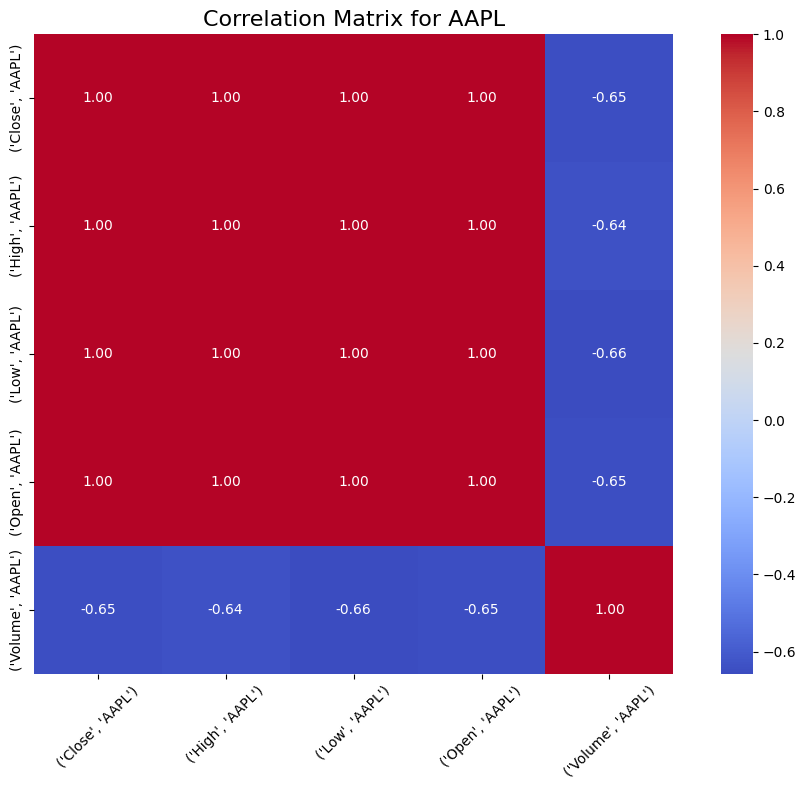

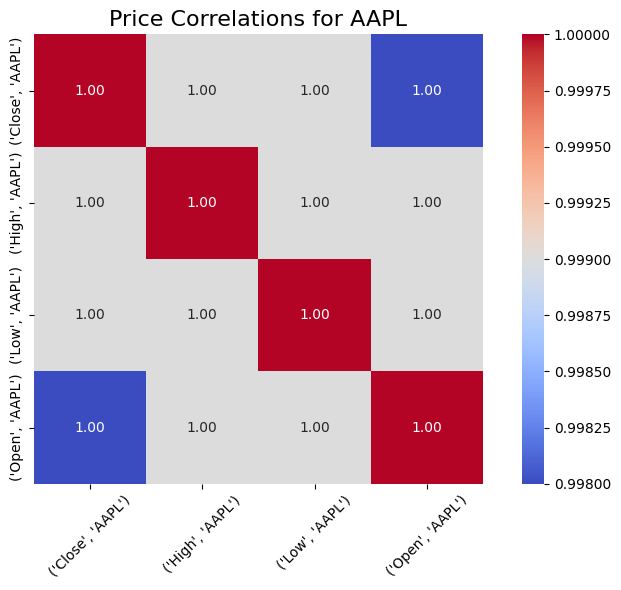


Correlation Analysis for MSFT


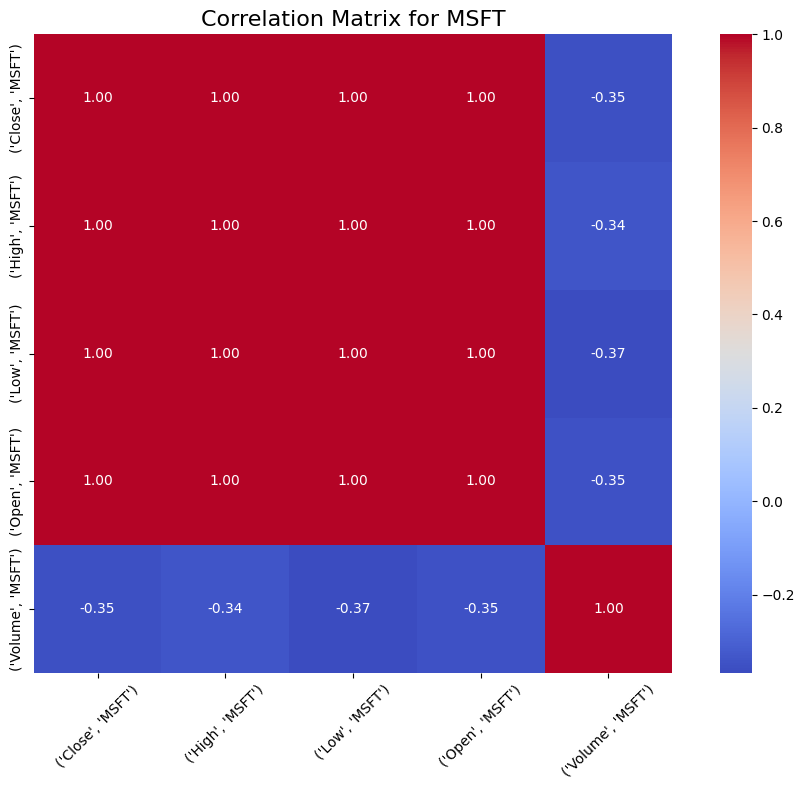

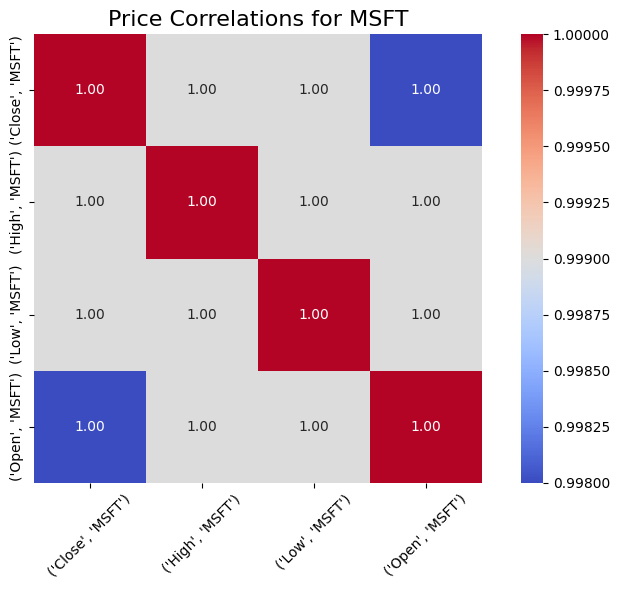


Correlation Analysis for GOOGL


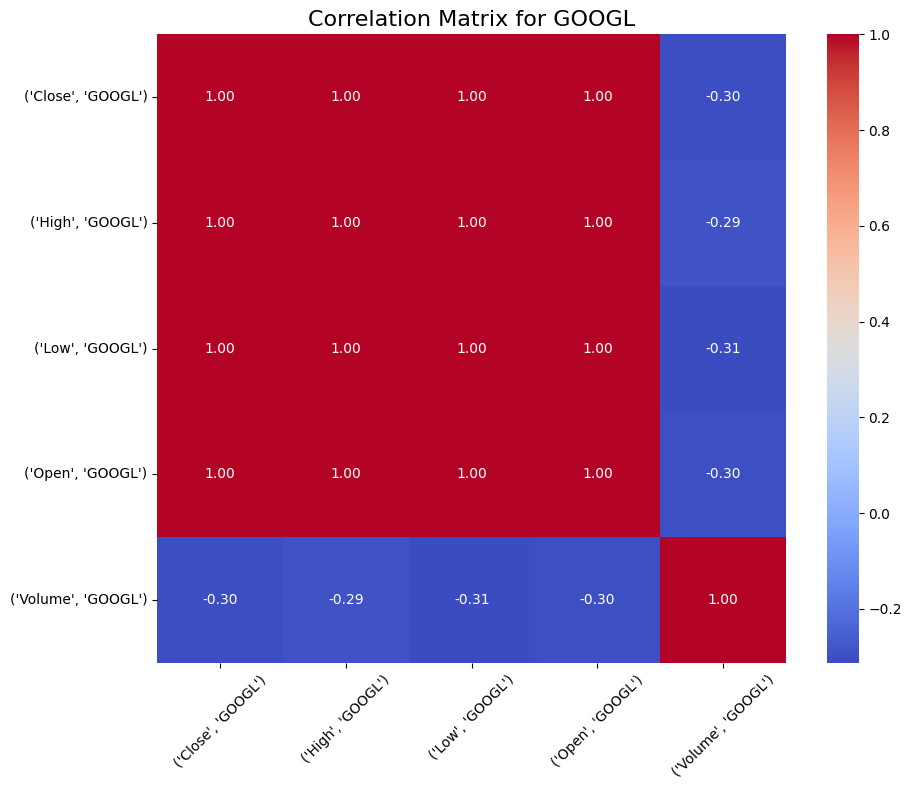

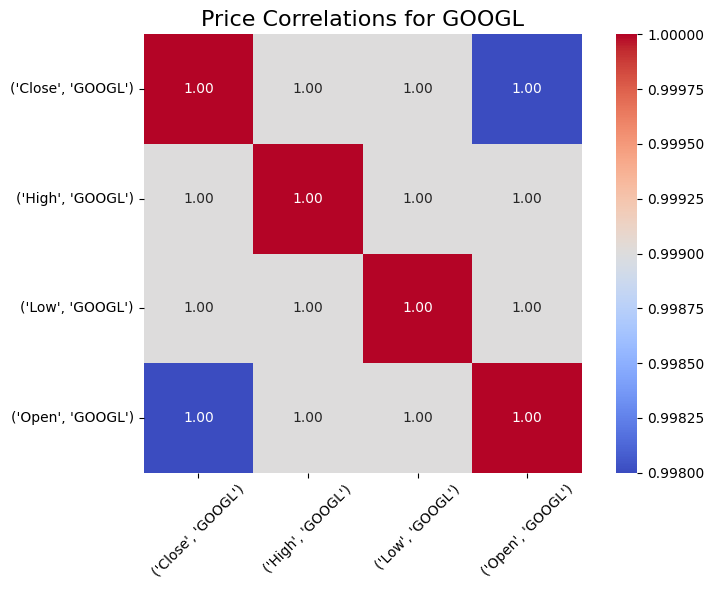


Correlation Analysis for AMZN


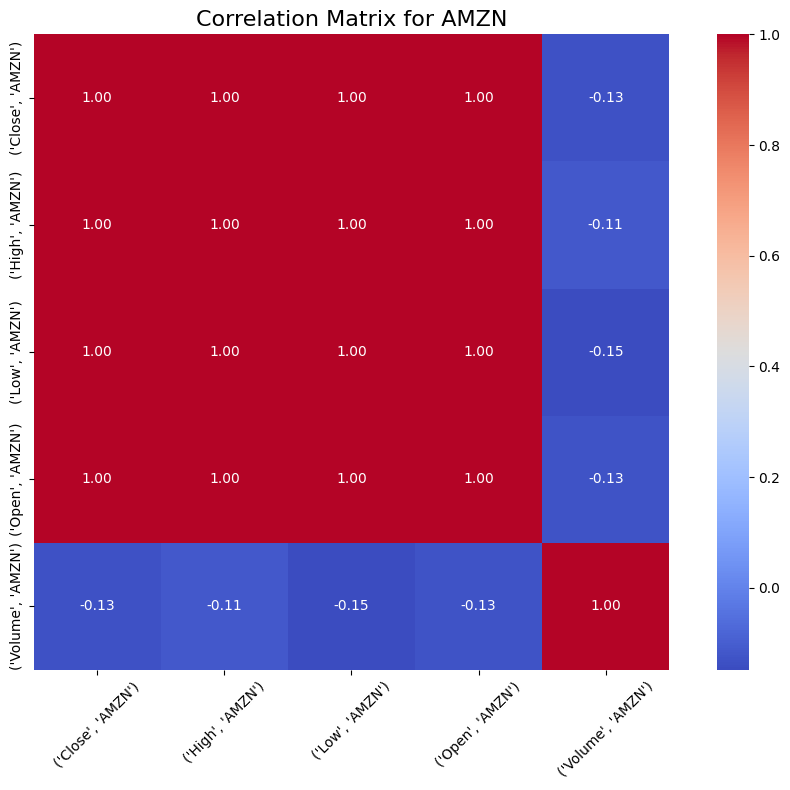

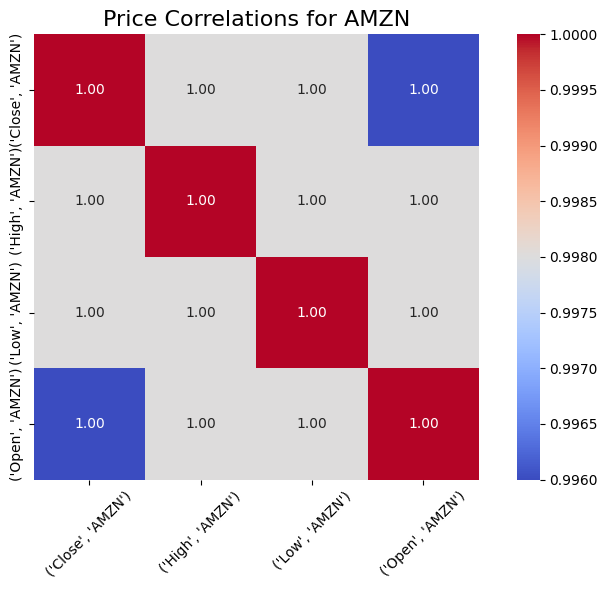

In [ ]:
def analyze_correlations(stock_data):

    #Iterate for each stock of the stock_data dictionnary
    for ticker, data in stock_data.items():
        print(f"\n{'='*80}")
        print(f"Correlation Analysis for {ticker}")
        print(f"{'='*80}")

        # We filter to include only the numeric columns and not the date columns
        numeric_cols = [c for c in data.columns if c != "('Date', '')"]

        correlations = {}

        #We loop through each pair of numeric values to calculate correlation
        for col1 in numeric_cols:
            correlations[col1] = {}
            for col2 in numeric_cols:
                #Calculate the correlation and store it
                correlation = data.select(corr(col1, col2)).collect()[0][0]
                correlations[col1][col2] = correlation

        #Convert to pandas for display
        corr_df = pd.DataFrame(correlations).round(3)

        #Display the correlation matrix with a heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
        plt.title(f"Correlation Matrix for {ticker}", fontsize=16)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


        #Create a price correlation matrix if there are price-related columns using a heatmap

        price_cols = [col for col in numeric_cols if any(price in col for price in ['Open', 'High', 'Low', 'Close', 'Adj Close'])]
        if price_cols:
            price_corr = corr_df.loc[price_cols, price_cols]
            plt.figure(figsize=(8, 6))
            sns.heatmap(price_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
            plt.title(f"Price Correlations for {ticker}", fontsize=16)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

#Call the function
analyze_correlations(stock_data)


#### The average opening and closing  prices

##### Here, the function we made computes and displays average opening and closing prices for each stock on yearly and monthly basis as requested
##### We added 2 graphs, one for yearly basis and one for monthly bases


Price Analysis for AAPL

Yearly Averages (in $):
+----+--------+---------+
|year|avg_open|avg_close|
+----+--------+---------+
|2020|   92.53|    92.61|
|2021|  137.73|   137.86|
|2022|   152.2|   152.23|
|2023|  170.39|   170.68|
+----+--------+---------+


Monthly Averages (in $):
+-----+--------+---------+
|month|avg_open|avg_close|
+-----+--------+---------+
|    1|  125.56|   125.67|
|    2|  129.66|   129.83|
|    3|  124.84|   125.12|
|    4|  129.06|   129.11|
|    5|  130.05|   130.11|
|    6|  131.73|   132.03|
|    7|  141.35|    141.8|
|    8|  151.48|   151.53|
|    9|  146.03|   145.42|
|   10|  142.42|   142.87|
|   11|  148.39|   148.67|
|   12|  155.12|   155.07|
+-----+--------+---------+



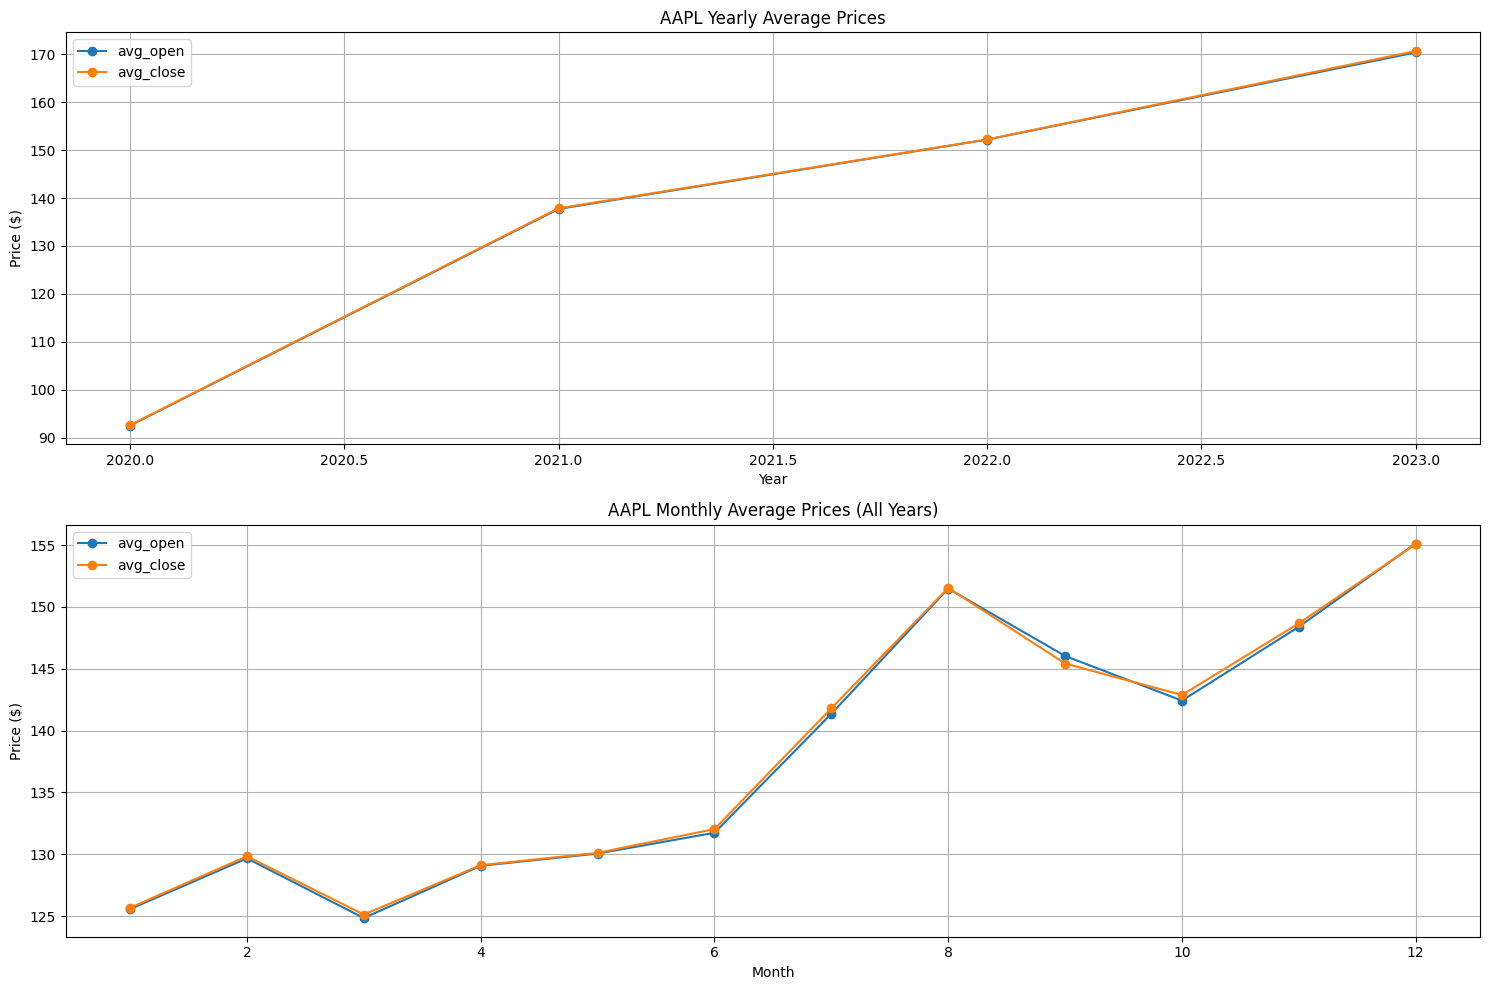


Price Analysis for MSFT

Yearly Averages (in $):
+----+--------+---------+
|year|avg_open|avg_close|
+----+--------+---------+
|2020|  184.54|   184.66|
|2021|  266.27|   266.53|
|2022|  261.97|   261.78|
|2023|  308.47|   308.72|
+----+--------+---------+


Monthly Averages (in $):
+-----+--------+---------+
|month|avg_open|avg_close|
+-----+--------+---------+
|    1|   224.8|    224.5|
|    2|  236.26|   236.36|
|    3|  230.47|   230.83|
|    4|   241.4|   241.34|
|    5|  246.89|   246.92|
|    6|   252.6|   253.18|
|    7|  263.52|   263.75|
|    8|  271.96|   271.95|
|    9|  262.66|   261.89|
|   10|  262.74|   263.31|
|   11|  282.05|   282.39|
|   12|  283.49|   283.66|
+-----+--------+---------+



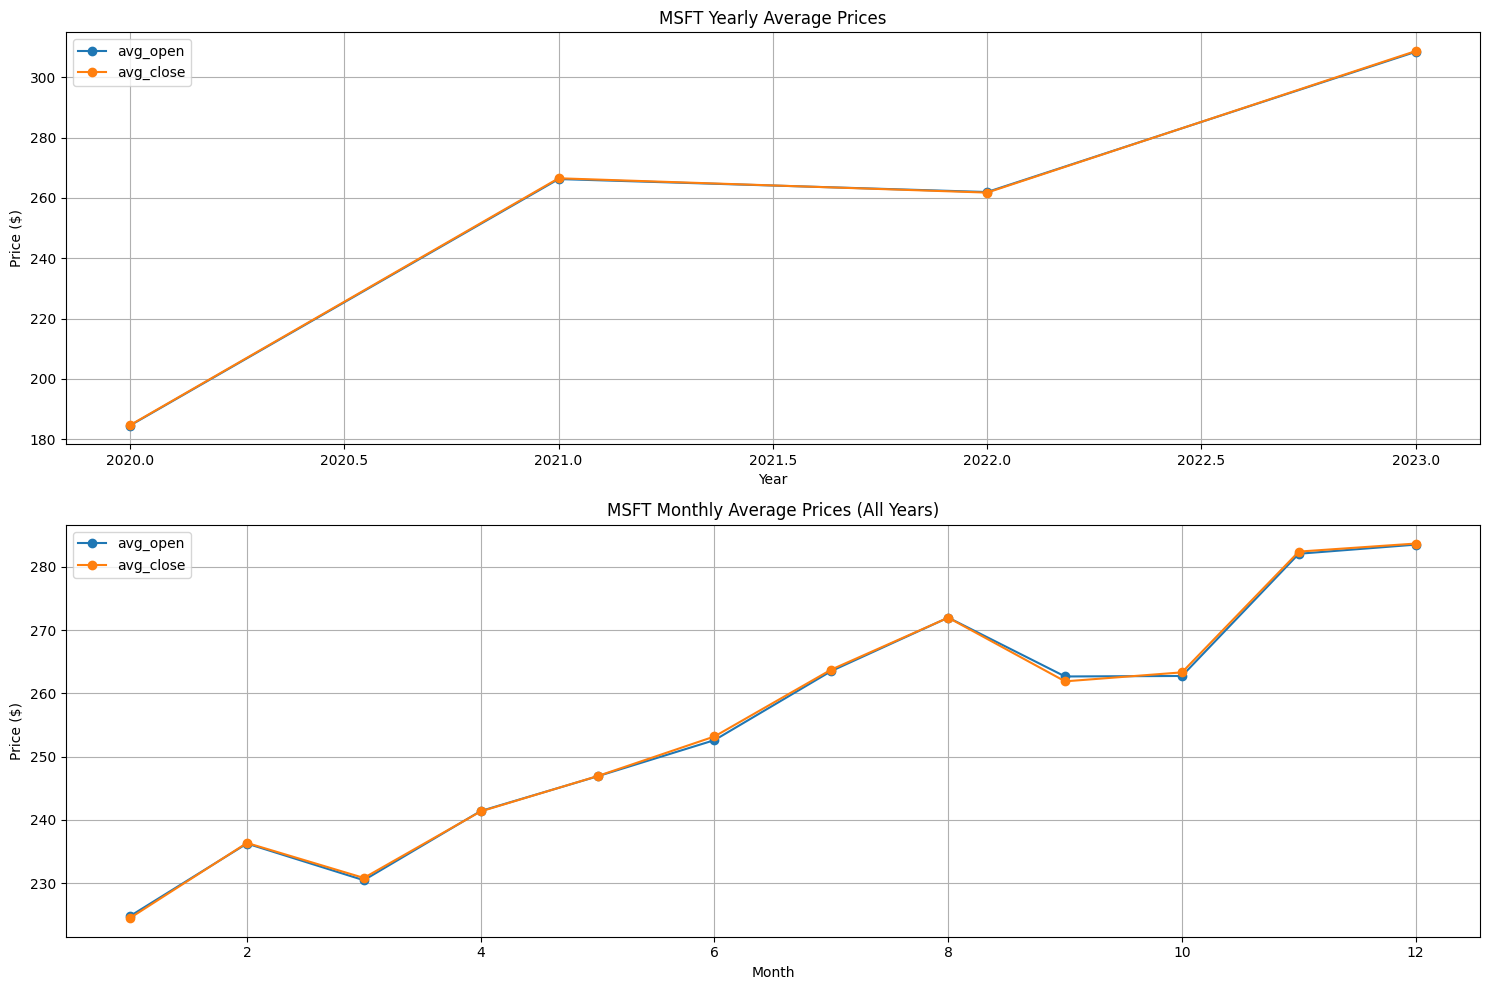


Price Analysis for GOOGL

Yearly Averages (in $):
+----+--------+---------+
|year|avg_open|avg_close|
+----+--------+---------+
|2020|   73.38|    73.44|
|2021|   123.3|   123.37|
|2022|  114.09|   113.97|
|2023|  117.74|   117.98|
+----+--------+---------+


Monthly Averages (in $):
+-----+--------+---------+
|month|avg_open|avg_close|
+-----+--------+---------+
|    1|   96.65|    96.81|
|    2|  101.63|   101.59|
|    3|   98.27|    98.42|
|    4|  101.31|   101.13|
|    5|   102.9|   103.16|
|    6|  105.82|   105.92|
|    7|  108.41|   108.66|
|    8|  115.29|   115.42|
|    9|  112.83|   112.57|
|   10|  111.39|   111.63|
|   11|  114.88|   114.85|
|   12|  114.38|   114.36|
+-----+--------+---------+



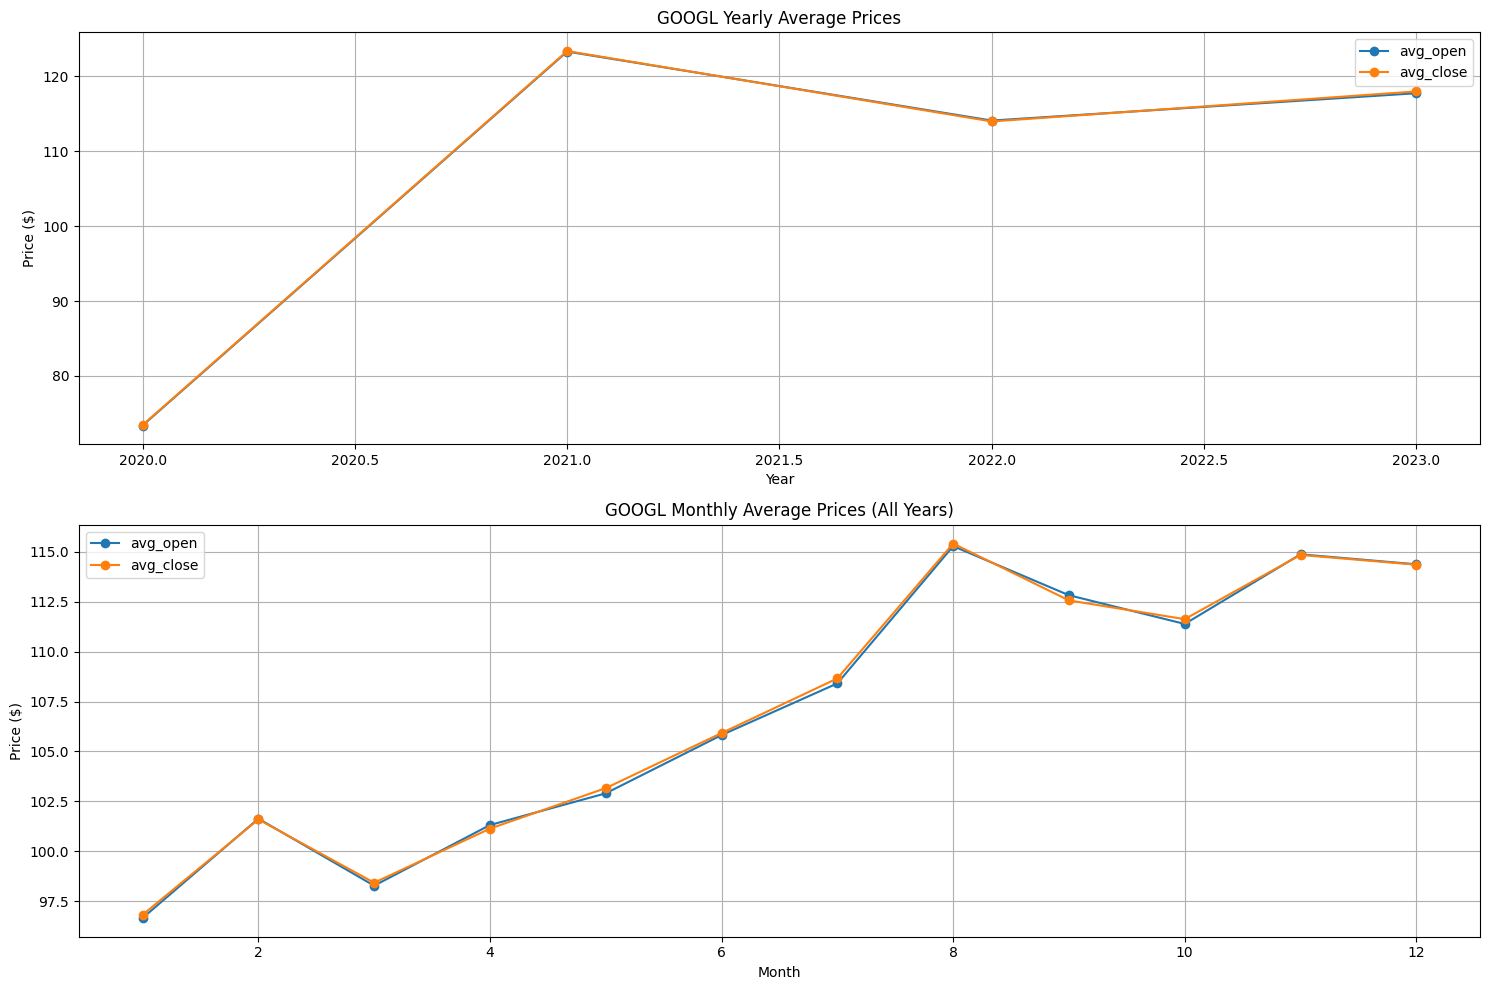


Price Analysis for AMZN

Yearly Averages (in $):
+----+--------+---------+
|year|avg_open|avg_close|
+----+--------+---------+
|2020|  134.05|   134.04|
|2021|  167.29|   167.19|
|2022|  126.32|    126.1|
|2023|  121.21|   121.37|
+----+--------+---------+


Monthly Averages (in $):
+-----+--------+---------+
|month|avg_open|avg_close|
+-----+--------+---------+
|    1|  125.24|   125.16|
|    2|  129.88|   129.88|
|    3|  124.76|    124.8|
|    4|  134.03|   133.95|
|    5|  126.09|   126.08|
|    6|  134.78|   134.92|
|    7|   145.7|   145.94|
|    8|  149.87|   149.82|
|    9|   147.5|   147.15|
|   10|  142.75|    142.8|
|   11|   142.6|   142.42|
|   12|  142.79|   142.58|
+-----+--------+---------+



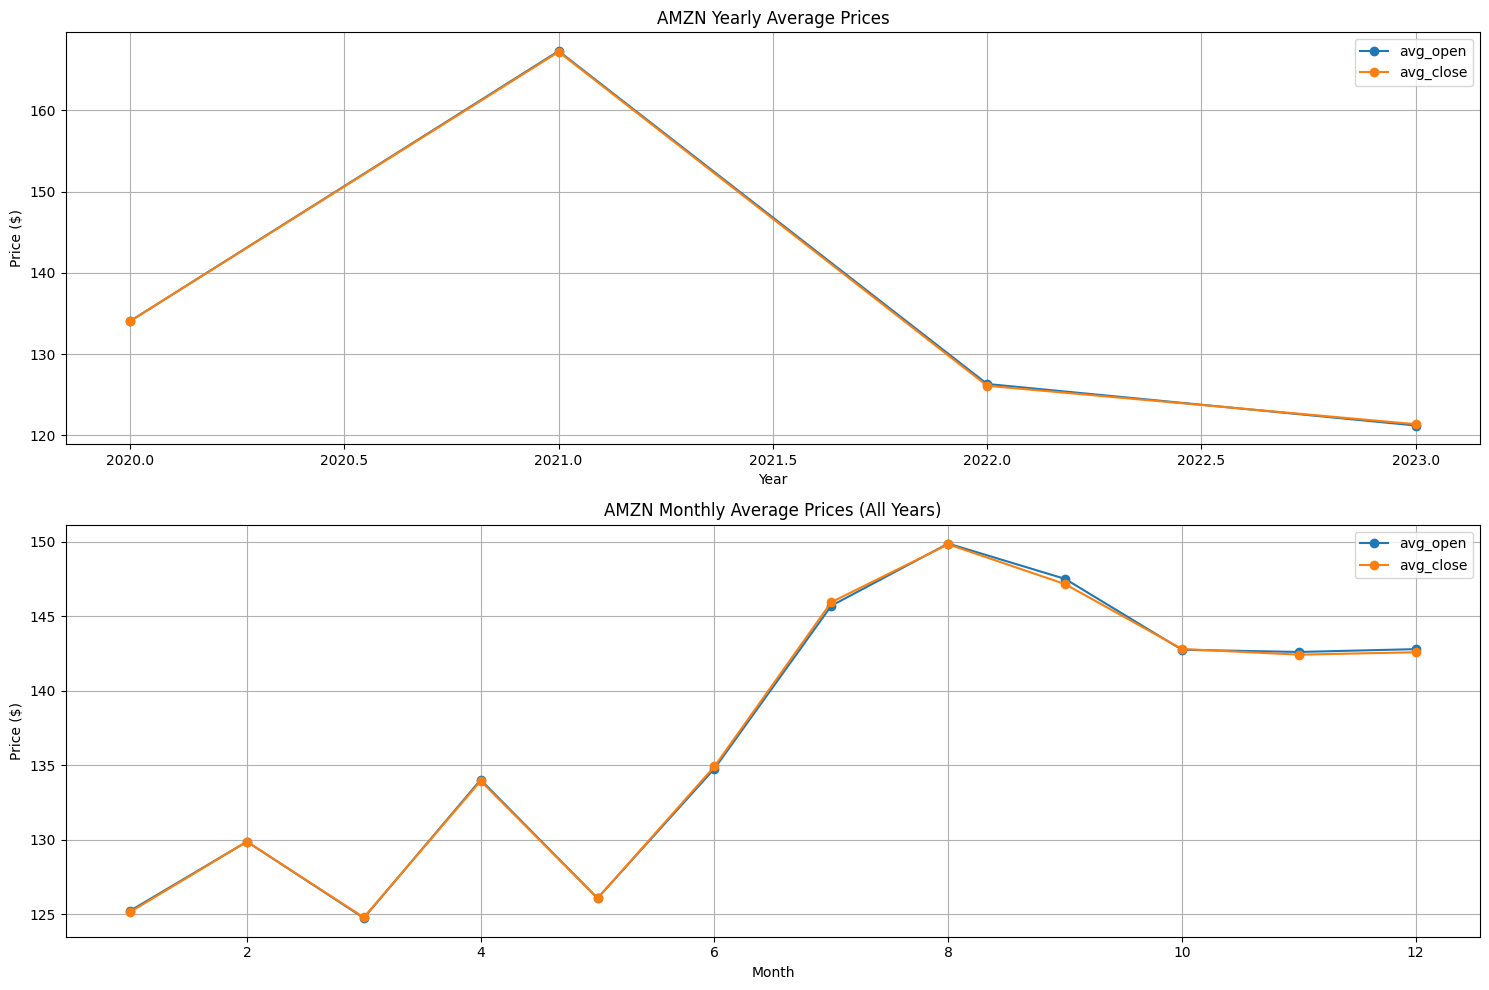

In [ ]:
def analyze_price_averages(stock_data):
    #Iterate for each stock of the stock_data dictionnary
    for ticker, data in stock_data.items():
        print(f"\n{'='*80}")
        print(f"Price Analysis for {ticker}")
        print(f"{'='*80}")

        #Define open_col and close_col with the name of the column of the stock_data dictionnary
        open_col = f"('Open', '{ticker}')"
        close_col = f"('Close', '{ticker}')"

        #We then add columns for the month and the year that have been extracted
        data = data.withColumn("year", year(col("('Date', '')"))) \
                  .withColumn("month", month(col("('Date', '')")))

        #Yearly average calculation of the opening and closing price
        yearly_avg = data.groupBy("year").agg(
            spark_round(mean(col(open_col)), 2).alias("avg_open"),
            spark_round(mean(col(close_col)), 2).alias("avg_close")
        ).orderBy("year")

        print("\nYearly Averages (in $):")
        yearly_avg.show()

        #Monthly average calculation of the opening and closing price
        monthly_avg = data.groupBy("month").agg(
            spark_round(mean(col(open_col)), 2).alias("avg_open"),
            spark_round(mean(col(close_col)), 2).alias("avg_close")
        ).orderBy("month")

        print("\nMonthly Averages (in $):")
        monthly_avg.show()

        #Convert to pandas for display
        yearly_avg_pandas = yearly_avg.toPandas()
        monthly_avg_pandas = monthly_avg.toPandas()

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

        #Plot yearly average
        yearly_avg_pandas.plot(x='year', y=['avg_open', 'avg_close'], marker='o', ax=ax1)
        ax1.set_title(f'{ticker} Yearly Average Prices')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Price ($)')
        ax1.grid(True)

        #Plot monthly average
        monthly_avg_pandas.plot(x='month', y=['avg_open', 'avg_close'], marker='o', ax=ax2)
        ax2.set_title(f'{ticker} Monthly Average Prices (All Years)')
        ax2.set_xlabel('Month')
        ax2.set_ylabel('Price ($)')
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

# Call the function
analyze_price_averages(stock_data)


#### Get the variation of the stock price

##### We calculate and display daily and monthly percentage changes in stock prices to track price movements over different time periods also called volatility.
##### We added another function which will use the ipywidgets library to be able to display buttons, dropdowns...
##### The user will be able to choose the date he want with dropdowns and then submit it with a button which will call the function.

In [ ]:
def analyze_price_variations(stock_data, start_date):
    # We create an Output widget to directly display results under the button
    output = widgets.Output()
    with output:
        #Iterate for each stock of the stock_data dictionnary
        for ticker, data in stock_data.items():
            print(f"\nPrice Variations for {ticker}")
            print("-" * 30)

            #We enter the start date we want. Therefore, here, we select the date after the start date we selected
            data = data.filter(col("('Date', '')") >= start_date)

            close_col = f"('Close', '{ticker}')"
            windowSpec = Window.orderBy("('Date', '')")

            # We then calculate daily and monthly price variations as percentage changes
            variations = data.withColumn(
                "daily_change_pct",
                spark_round((col(close_col) - lag(col(close_col)).over(windowSpec)) /
                            lag(col(close_col)).over(windowSpec) * 100, 2)
            ).withColumn(
                "monthly_change_pct",
                spark_round((col(close_col) - lag(col(close_col), 30).over(windowSpec)) /
                            lag(col(close_col), 30).over(windowSpec) * 100, 2)
            )

            # We display the first 5 rows of price variations
            print("\nSample of price variations:")
            variations.select(
                "('Date', '')",
                close_col,
                "daily_change_pct",
                "monthly_change_pct"
            ).show(5)

    return output


#Function to choose the date we want
def display_analyze_price_variations(stock_data):
    #A year dropdown to choose the year we want with 2020, 2021, 2022 and 2023 options
    year_dropdown = widgets.Dropdown(
        options=[2020, 2021, 2022, 2023],
        description='Year:'
    )

    #A month dropdown to choose the month we want
    month_dropdown = widgets.Dropdown(
        options=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        description='Month:'
    )

    #A day dropdown to choose the month we want
    day_dropdown = widgets.Dropdown(
        options=[i for i in range(1, 32)],
        description='Day:'
    )

    #Button to submit
    button = widgets.Button(
        description="Analyze price variations",
        layout=widgets.Layout(width='200px')
    )

    #Widget for output
    output_widget = widgets.Output()

    #Def of what will happend when we will click on the button
    def on_button_click(b):
        #Take the value we selected in the dropdowns
        year = year_dropdown.value
        month = month_dropdown.value
        day = day_dropdown.value

        #Convert the different day, month and year to a date
        start_date = f"{year}-{month:02d}-{day:02d}"

        #Call the principal function
        result_output = analyze_price_variations(stock_data, start_date)

        #delete the precedent output if there is one
        output_widget.clear_output(wait=True)
        with output_widget:
            #Display the output
            display(result_output)

    #When we click on the button, call the function def on button click
    button.on_click(on_button_click)

    #For beauty organize buttons and dropdown where we want
    date_widgets = widgets.HBox([day_dropdown, month_dropdown, year_dropdown], layout=widgets.Layout(justify_content='center', margin='20px 20px'))
    button_container = widgets.HBox([button], layout=widgets.Layout(justify_content='center', margin='20px 0px'))

    #Display everything
    display(date_widgets, button_container, output_widget)

#Call the function
display_analyze_price_variations(stock_data)




Output()

#### Get the daily return based on the opening and closing price

##### We compute the daily return rate ((Close-Open)/Open * 100) to measure daily stock performance.
##### The user will also be able to enter the date he want with dropdowns and submit it with a button.
##### Moreover, we use a graph to illustrate the daily return rate for the following 5 days that are after the day we selected

In [ ]:
def calculate_daily_returns(stock_data, start_date):
    # We create an Output widget to directly display results under the button
    output_widget = widgets.Output()

    with output_widget:
        #Iterate for each stock of the stock_data dictionnary
        for ticker, data in stock_data.items():
            print(f"\nDaily Returns for {ticker}")
            print("=" * 50)

            #Column for open and close prices of the stock
            close_col = f"('Close', '{ticker}')"
            open_col = f"('Open', '{ticker}')"

            data = data.withColumn("date", to_date(col("('Date', '')")))

            # Calculate daily returns in percentage
            data_with_returns = data.withColumn(
                "daily_return",
                spark_round((col(close_col) - col(open_col)) / col(open_col) * 100, 2)
            )

            #Filter data from the given date to the next 5 days (except non working days)
            filtered_data = data_with_returns.filter(
                col("date") >= lit(start_date)
            ).orderBy("date").limit(5)

            # Calculate the average daily return for the next 5 days
            avg_return = filtered_data.select(
                spark_round(mean("daily_return"), 2).alias("avg_return")
            ).collect()[0]['avg_return']
            print(f"Average Daily Return for {ticker} (Next 5 Days): {avg_return}%")
            print("\n")

            #Convert to pandas for plotting
            filtered_data_pandas = filtered_data.select(
                col("date"),
                col("daily_return")
            ).toPandas()


            #plot the daily returns
            plt.figure(figsize=(10, 6))
            plt.plot(
                filtered_data_pandas['date'],
                filtered_data_pandas['daily_return'],
                marker='o',
                label=ticker
            )
            plt.title(f"{ticker} Daily Returns from {start_date} (Next 5 Days which are only working days)")
            plt.xlabel("Date")
            plt.ylabel("Daily Return (%)")

            #To display the date well on the x axis
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.gca().xaxis.set_major_locator(mdates.DayLocator())
            plt.xticks(rotation=45)

            plt.gca().tick_params(axis='x', labelrotation=45)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()



    return output_widget

def display_calculate_daily_returns():
    #A year dropdown to choose the year we want with 2020, 2021, 2022 and 2023 options
    year_dropdown = widgets.Dropdown(
        options=[2020, 2021, 2022, 2023],
        description='Year:'
    )

    #A month dropdown to choose the month we want
    month_dropdown = widgets.Dropdown(
        options=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        description='Month:'
    )

    #A day dropdown to choose the month we want
    day_dropdown = widgets.Dropdown(
        options=[i for i in range(1, 32)],
        description='Day:'
    )

    #Button to submit
    button = widgets.Button(
        description="Calculate Daily Returns",
        layout=widgets.Layout(width='200px')
    )

    output_widget = widgets.Output()

    #Def of what will happend when we will click on the button
    def on_button_click(b):
        #Take the value we selected in the dropdowns
        year = year_dropdown.value
        month = month_dropdown.value
        day = day_dropdown.value

        #Convert the different day, month and year to a date
        start_date = f"{year}-{month:02d}-{day:02d}"

        #Call the principal function
        result_output = calculate_daily_returns(stock_data, start_date)

        #delete the precedent output if there is one
        output_widget.clear_output(wait=True)
        with output_widget:
            #Display the output
            display(result_output)

    #When we click on the button, call the function def on button click
    button.on_click(on_button_click)

    #For beauty organize buttons and dropdown where we want
    date_widgets = widgets.HBox([day_dropdown, month_dropdown, year_dropdown], layout=widgets.Layout(justify_content='center', margin='20px 20px'))
    button_container = widgets.HBox([button], layout=widgets.Layout(justify_content='center', margin='20px 0px'))

    #Display everything
    display(date_widgets, button_container, output_widget)

#Call the function
display_calculate_daily_returns()




Output()

#### Find the highest daily return among the stocks

##### We identify the highest daily return for each stock and shows when it occurred

In [ ]:
def find_highest_daily_returns(stock_data):
    print("\nHighest Daily Return for Each Stock:")
    print("=" * 60)

    #Iterate for each stock of the stock_data dictionnary
    for ticker, data in stock_data.items():
        # Get column names
        close_col = f"('Close', '{ticker}')"
        open_col = f"('Open', '{ticker}')"

        # Calculate daily returns
        data_with_returns = data.withColumn(
            "daily_return",
            spark_round((col(close_col) - col(open_col)) / col(open_col) * 100, 2)
        )

        # to find the  maximum return and its corresponding date
        windowSpec = Window.orderBy(col("daily_return").desc())

        #Find the highest return for each stock in the data
        max_return_data = data_with_returns \
            .withColumn("rank", row_number().over(windowSpec)) \
            .filter(col("rank") == 1) \
            .select("('Date', '')", "daily_return") \
            .collect()[0]

        #Extract the return date and the daily return rate for the highest daily return rate value
        max_date = max_return_data["('Date', '')"]
        max_return = max_return_data["daily_return"]

        print(f"\n{ticker}:")
        print(f"Highest Return: {max_return}%")
        print(f"Date: {max_date}")

    return data_with_returns

# Analyze highest returns
returns_data = find_highest_daily_returns(stock_data)


Highest Daily Return for Each Stock:

AAPL:
Highest Return: 6.66%
Date: 2022-02-24 00:00:00

MSFT:
Highest Return: 8.1%
Date: 2022-02-24 00:00:00

GOOGL:
Highest Return: 6.51%
Date: 2022-11-30 00:00:00

AMZN:
Highest Return: 8.24%
Date: 2022-02-24 00:00:00


#### We want to know the average daily return depending the period

##### We need to analyze average daily returns across different time periods, so that we could take some insights such as the best performance year.
##### We illustrate the differents values we found in the table with 3 graphs, one for the yearly average returns, a second for monthly average returns and a last one for weekly average returns


Period Returns Analysis for AAPL

Yearly Average Returns (in %):
+----+----------------+
|year|avg_daily_return|
+----+----------------+
|2020|            0.15|
|2021|            0.09|
|2022|            0.04|
|2023|            0.19|
+----+----------------+


Monthly Average Returns (in %):
+----+-----+----------------+
|year|month|avg_daily_return|
+----+-----+----------------+
|2023|   12|            0.05|
|2023|   11|            0.35|
|2023|   10|            0.37|
|2023|    9|           -0.32|
|2023|    8|           -0.17|
|2023|    7|           -0.05|
|2023|    6|            0.33|
|2023|    5|            0.07|
|2023|    4|            0.37|
|2023|    3|            0.33|
|2023|    2|             0.5|
|2023|    1|            0.47|
+----+-----+----------------+


Weekly Average Returns (in %):
+----+----+----------------+
|year|week|avg_daily_return|
+----+----+----------------+
|2023|  52|           -0.24|
|2023|  51|           -0.46|
|2023|  50|            0.48|
|2023|  49|          

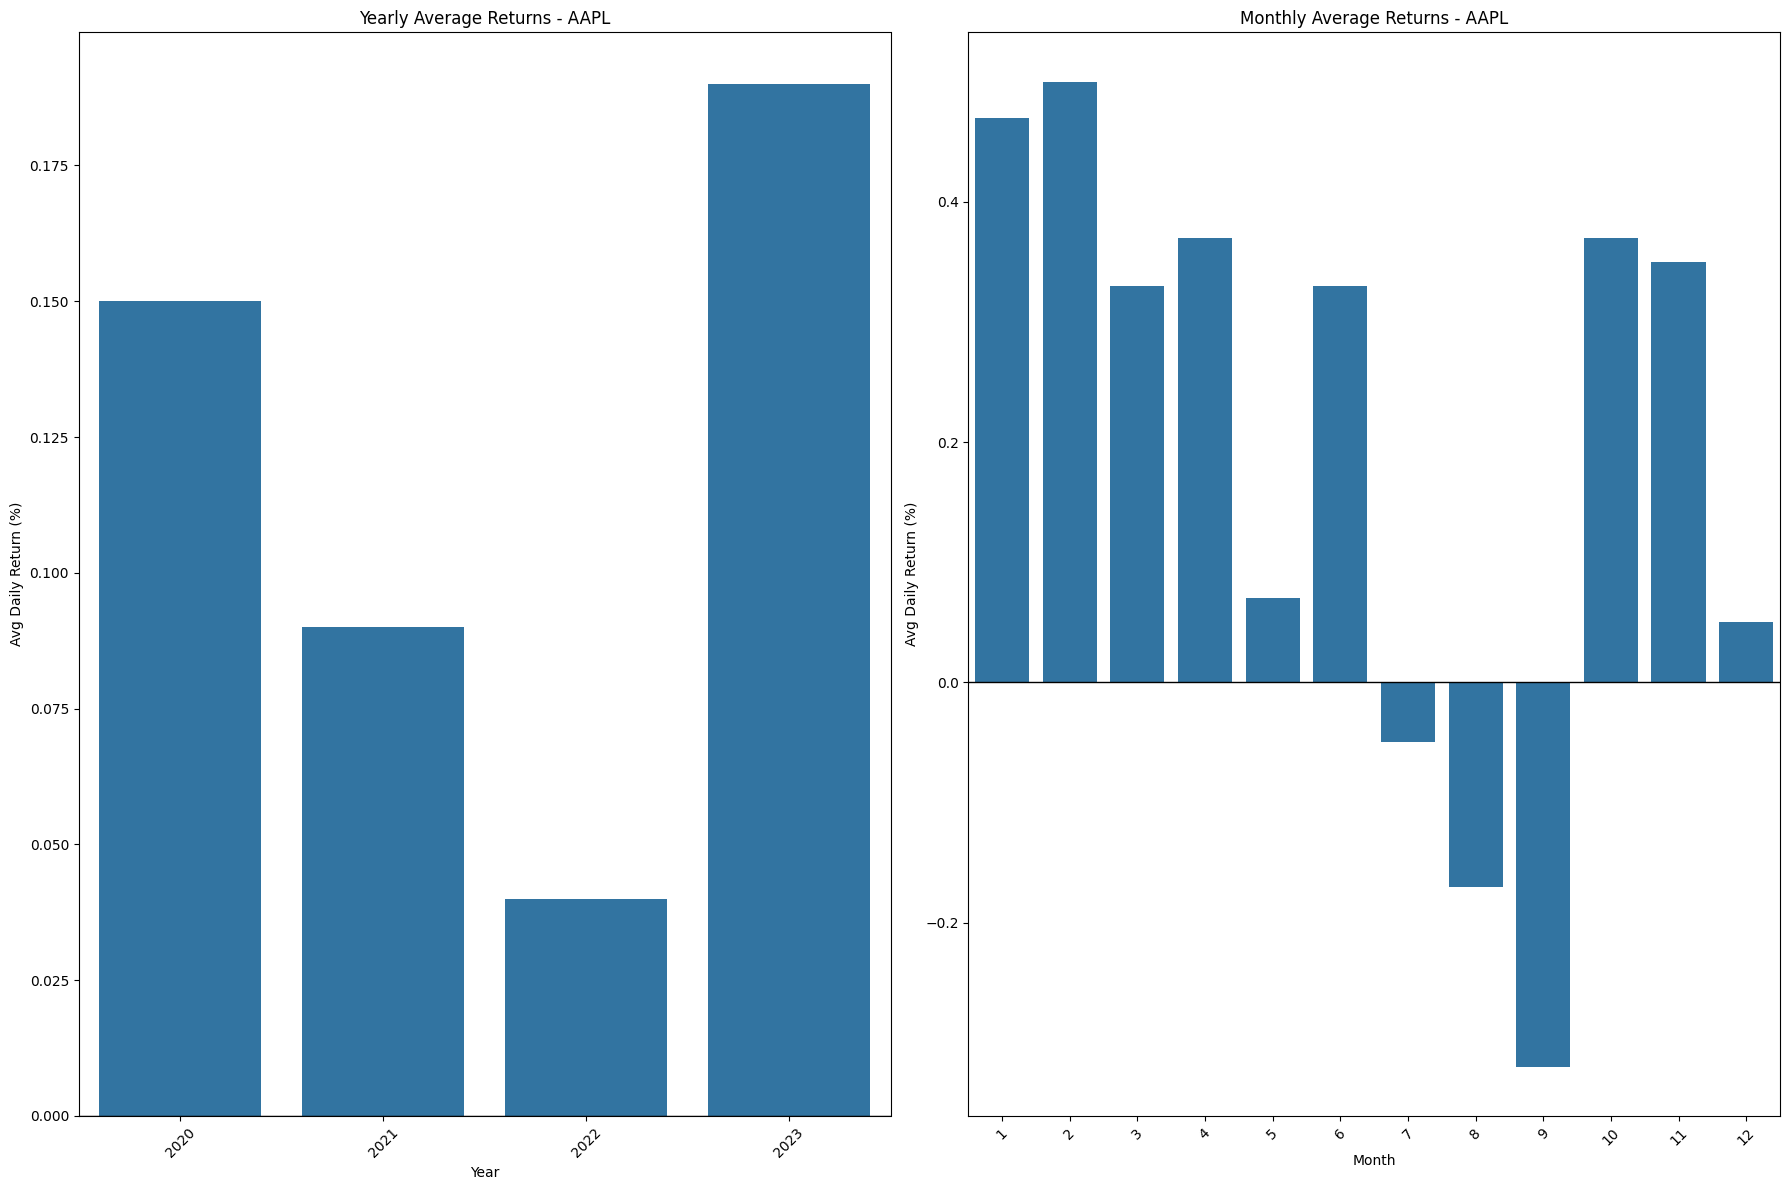

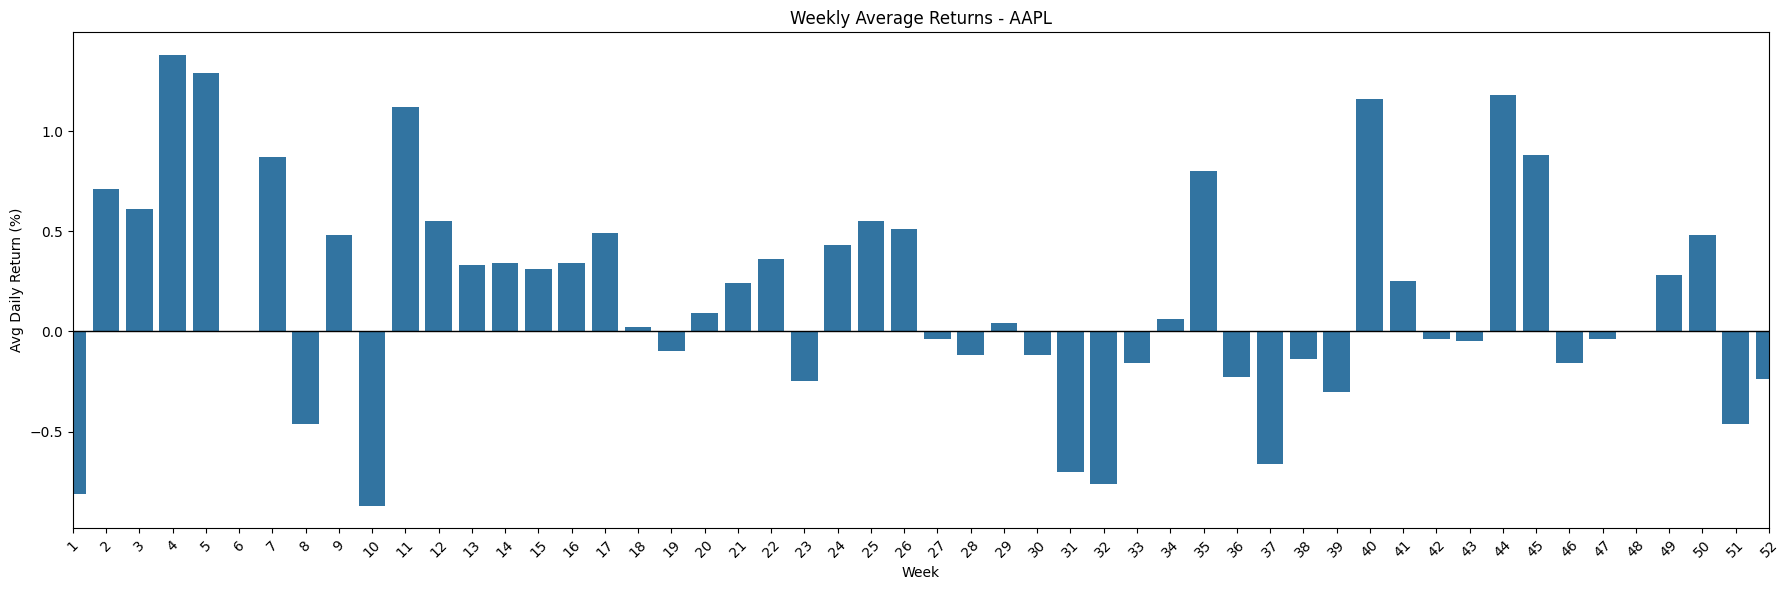


Period Returns Analysis for MSFT

Yearly Average Returns (in %):
+----+----------------+
|year|avg_daily_return|
+----+----------------+
|2020|            0.08|
|2021|            0.11|
|2022|           -0.04|
|2023|            0.09|
+----+----------------+


Monthly Average Returns (in %):
+----+-----+----------------+
|year|month|avg_daily_return|
+----+-----+----------------+
|2023|   12|            0.15|
|2023|   11|            0.35|
|2023|   10|           -0.01|
|2023|    9|           -0.17|
|2023|    8|           -0.24|
|2023|    7|           -0.11|
|2023|    6|             0.2|
|2023|    5|            0.12|
|2023|    4|            0.27|
|2023|    3|            0.35|
|2023|    2|           -0.11|
|2023|    1|            0.33|
+----+-----+----------------+


Weekly Average Returns (in %):
+----+----+----------------+
|year|week|avg_daily_return|
+----+----+----------------+
|2023|  52|             0.0|
|2023|  51|            0.14|
|2023|  50|            0.07|
|2023|  49|          

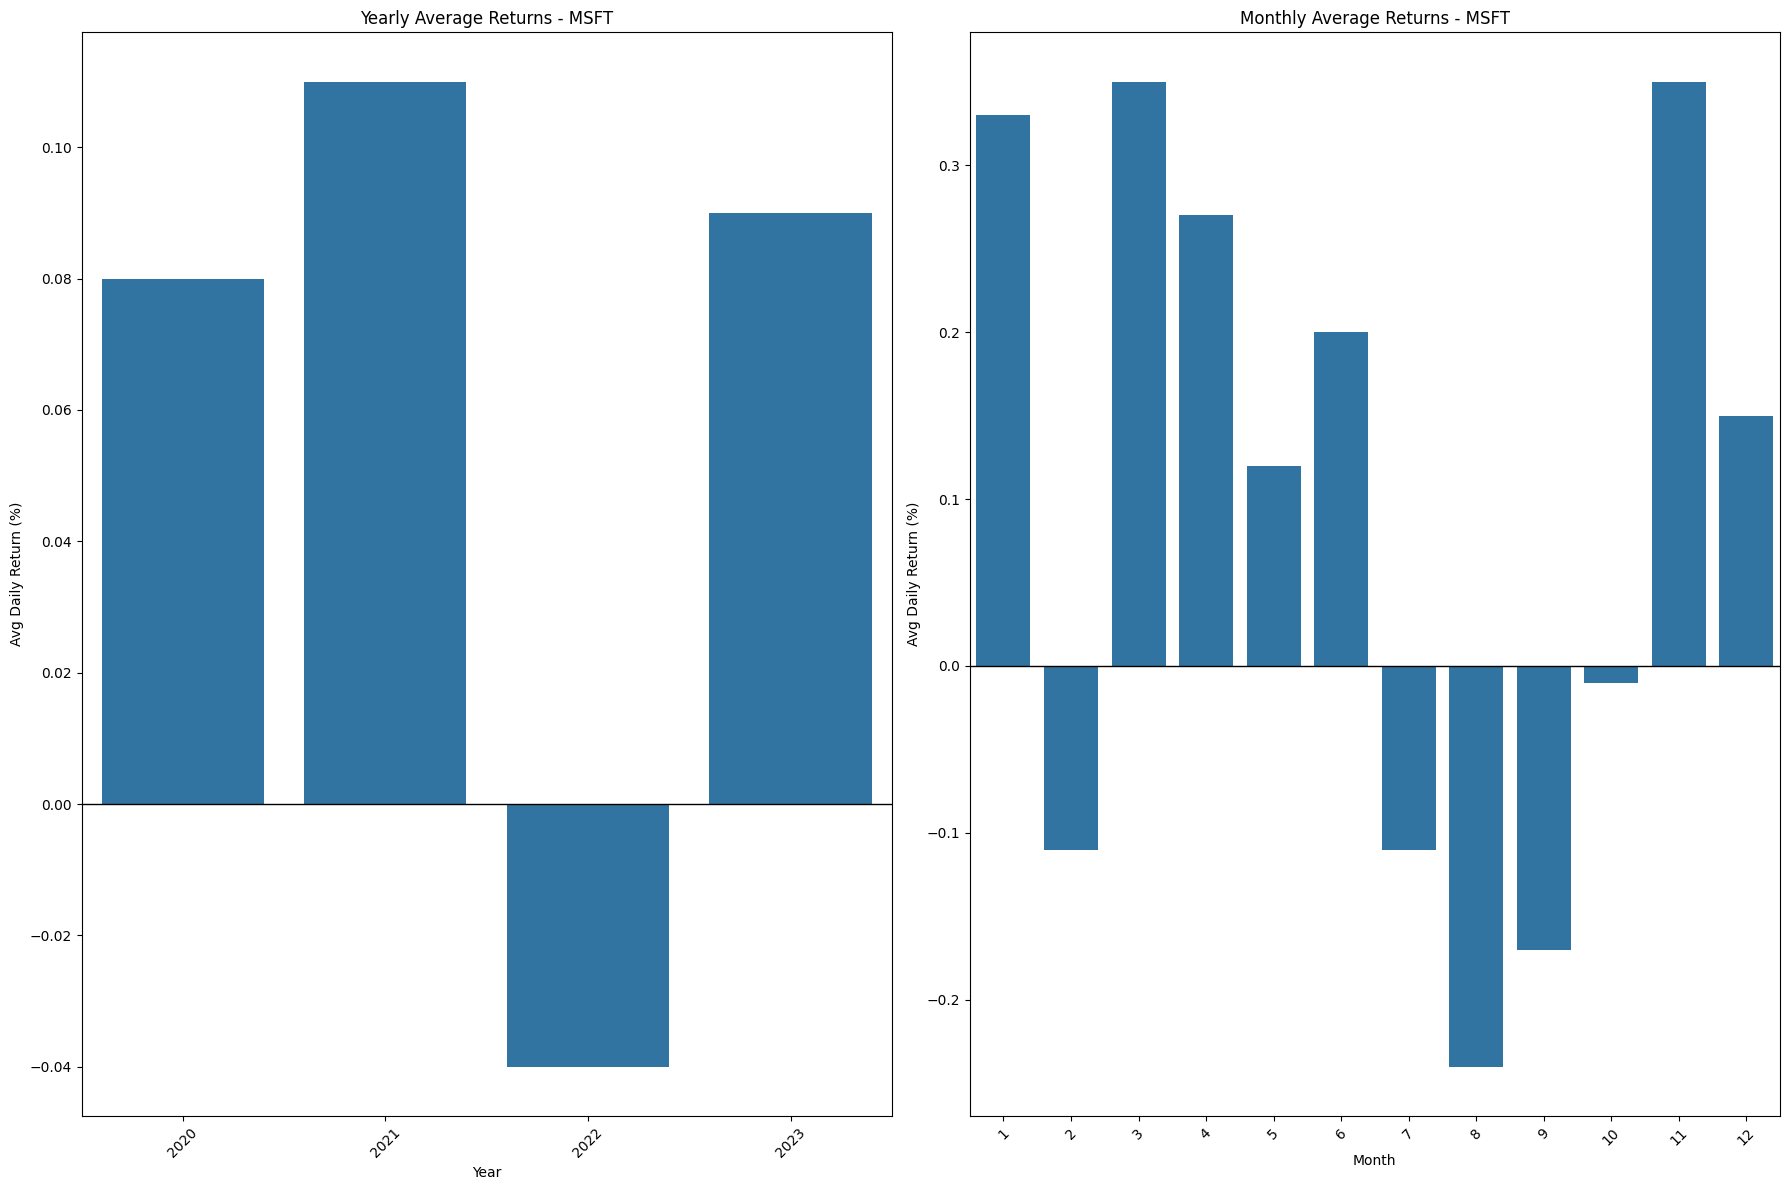

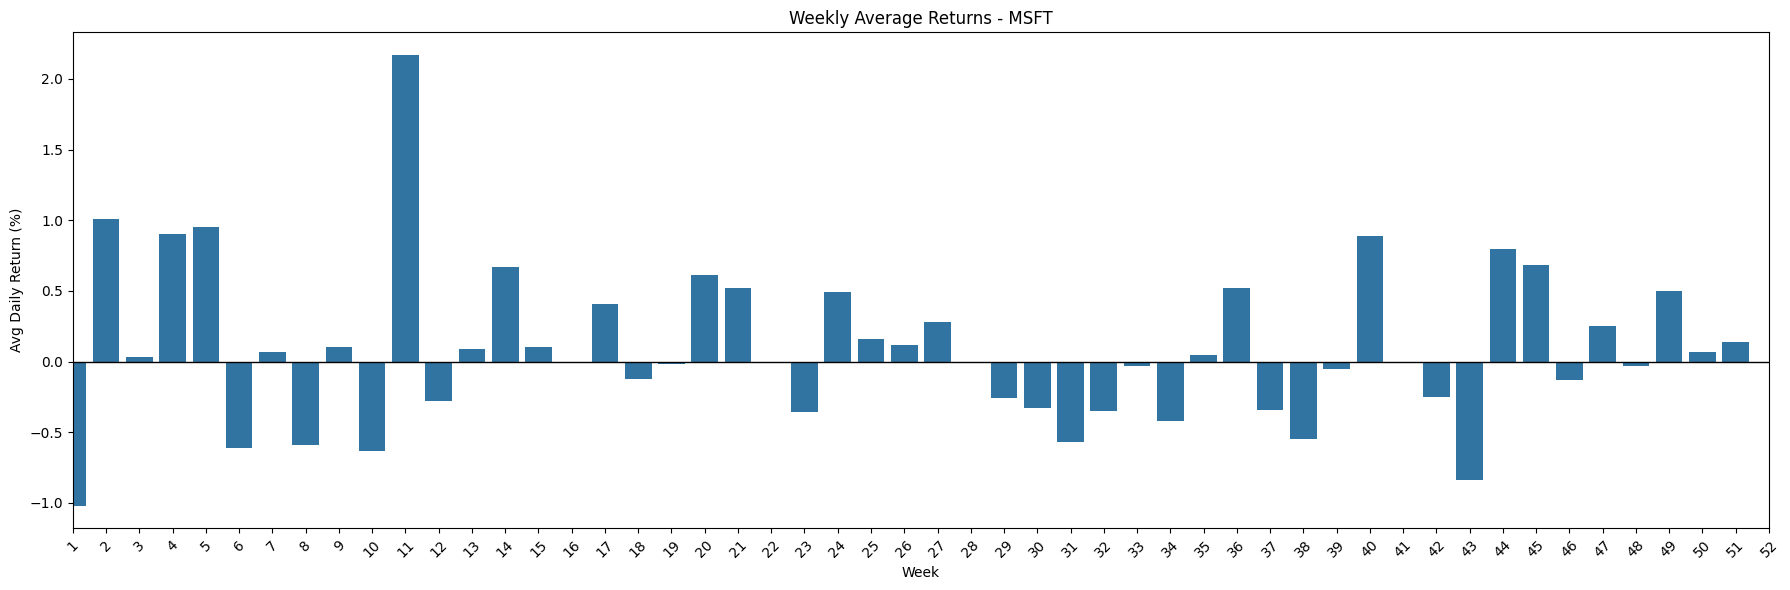


Period Returns Analysis for GOOGL

Yearly Average Returns (in %):
+----+----------------+
|year|avg_daily_return|
+----+----------------+
|2020|            0.11|
|2021|            0.08|
|2022|           -0.07|
|2023|            0.23|
+----+----------------+


Monthly Average Returns (in %):
+----+-----+----------------+
|year|month|avg_daily_return|
+----+-----+----------------+
|2023|   12|             0.2|
|2023|   11|            0.21|
|2023|   10|             0.1|
|2023|    9|           -0.01|
|2023|    8|            0.09|
|2023|    7|           -0.06|
|2023|    6|            0.16|
|2023|    5|            0.42|
|2023|    4|            0.31|
|2023|    3|            0.66|
|2023|    2|             0.1|
|2023|    1|            0.58|
+----+-----+----------------+


Weekly Average Returns (in %):
+----+----+----------------+
|year|week|avg_daily_return|
+----+----+----------------+
|2023|  52|           -0.32|
|2023|  51|             0.6|
|2023|  50|            0.06|
|2023|  49|         

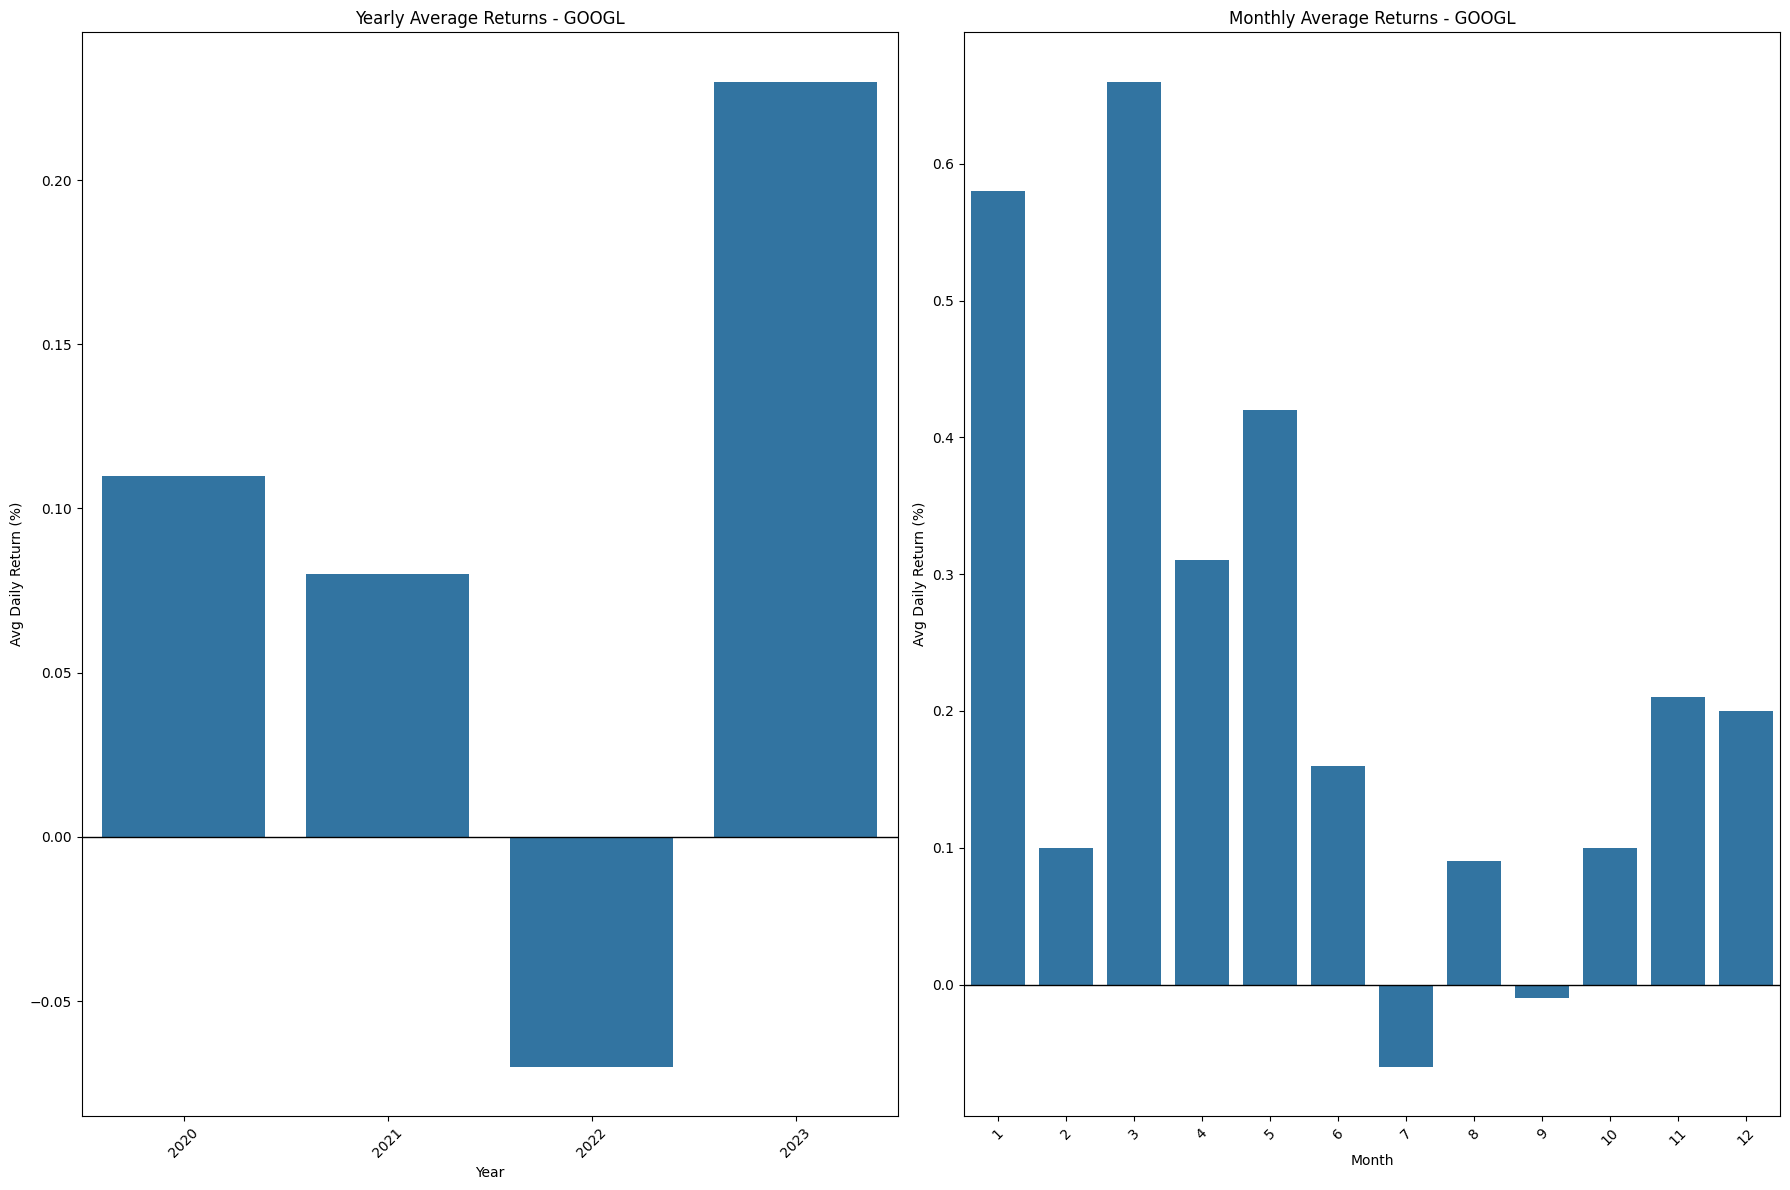

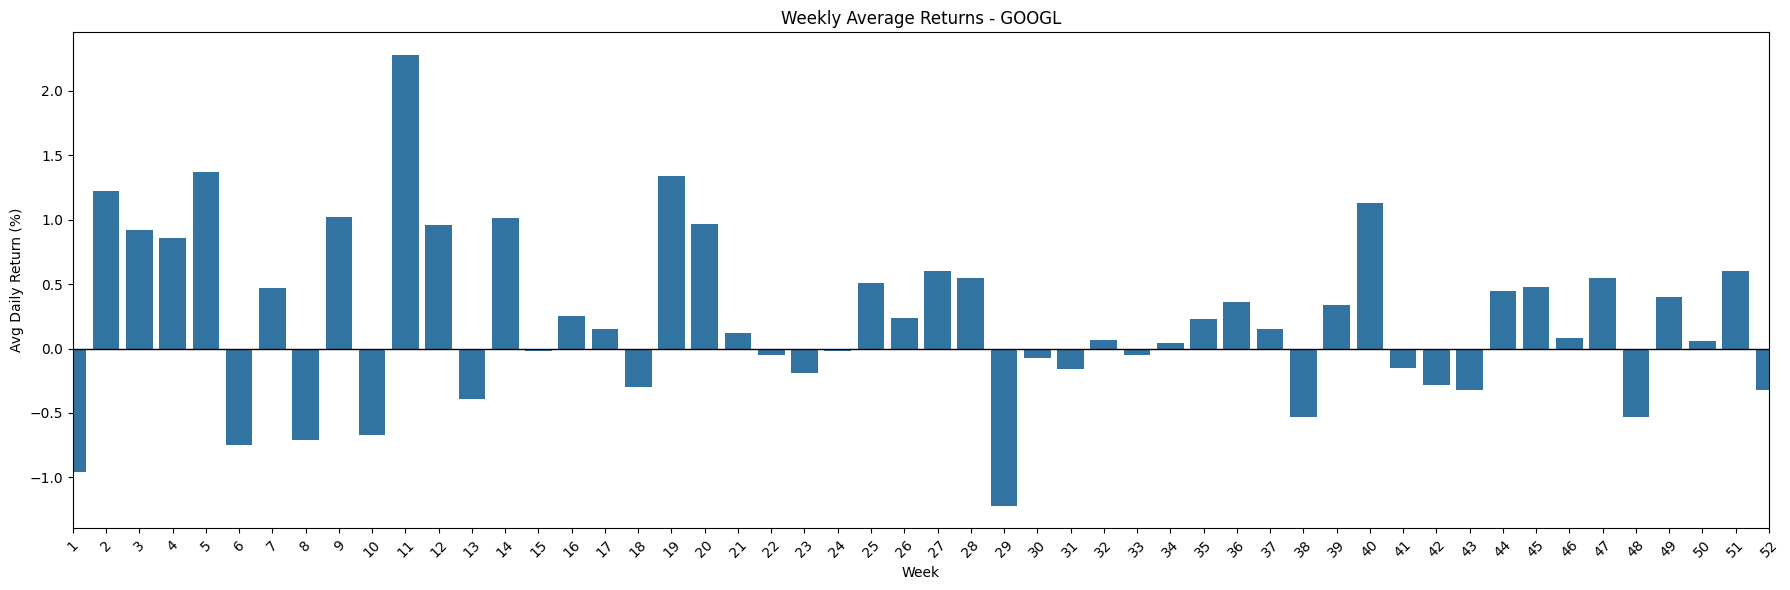


Period Returns Analysis for AMZN

Yearly Average Returns (in %):
+----+----------------+
|year|avg_daily_return|
+----+----------------+
|2020|            0.06|
|2021|           -0.05|
|2022|           -0.15|
|2023|            0.16|
+----+----------------+


Monthly Average Returns (in %):
+----+-----+----------------+
|year|month|avg_daily_return|
+----+-----+----------------+
|2023|   12|            0.21|
|2023|   11|            0.38|
|2023|   10|             0.1|
|2023|    9|           -0.13|
|2023|    8|           -0.17|
|2023|    7|            -0.1|
|2023|    6|            0.16|
|2023|    5|            0.32|
|2023|    4|           -0.05|
|2023|    3|            0.27|
|2023|    2|            0.11|
|2023|    1|            0.84|
+----+-----+----------------+


Weekly Average Returns (in %):
+----+----+----------------+
|year|week|avg_daily_return|
+----+----+----------------+
|2023|  52|           -0.31|
|2023|  51|            0.31|
|2023|  50|            0.28|
|2023|  49|          

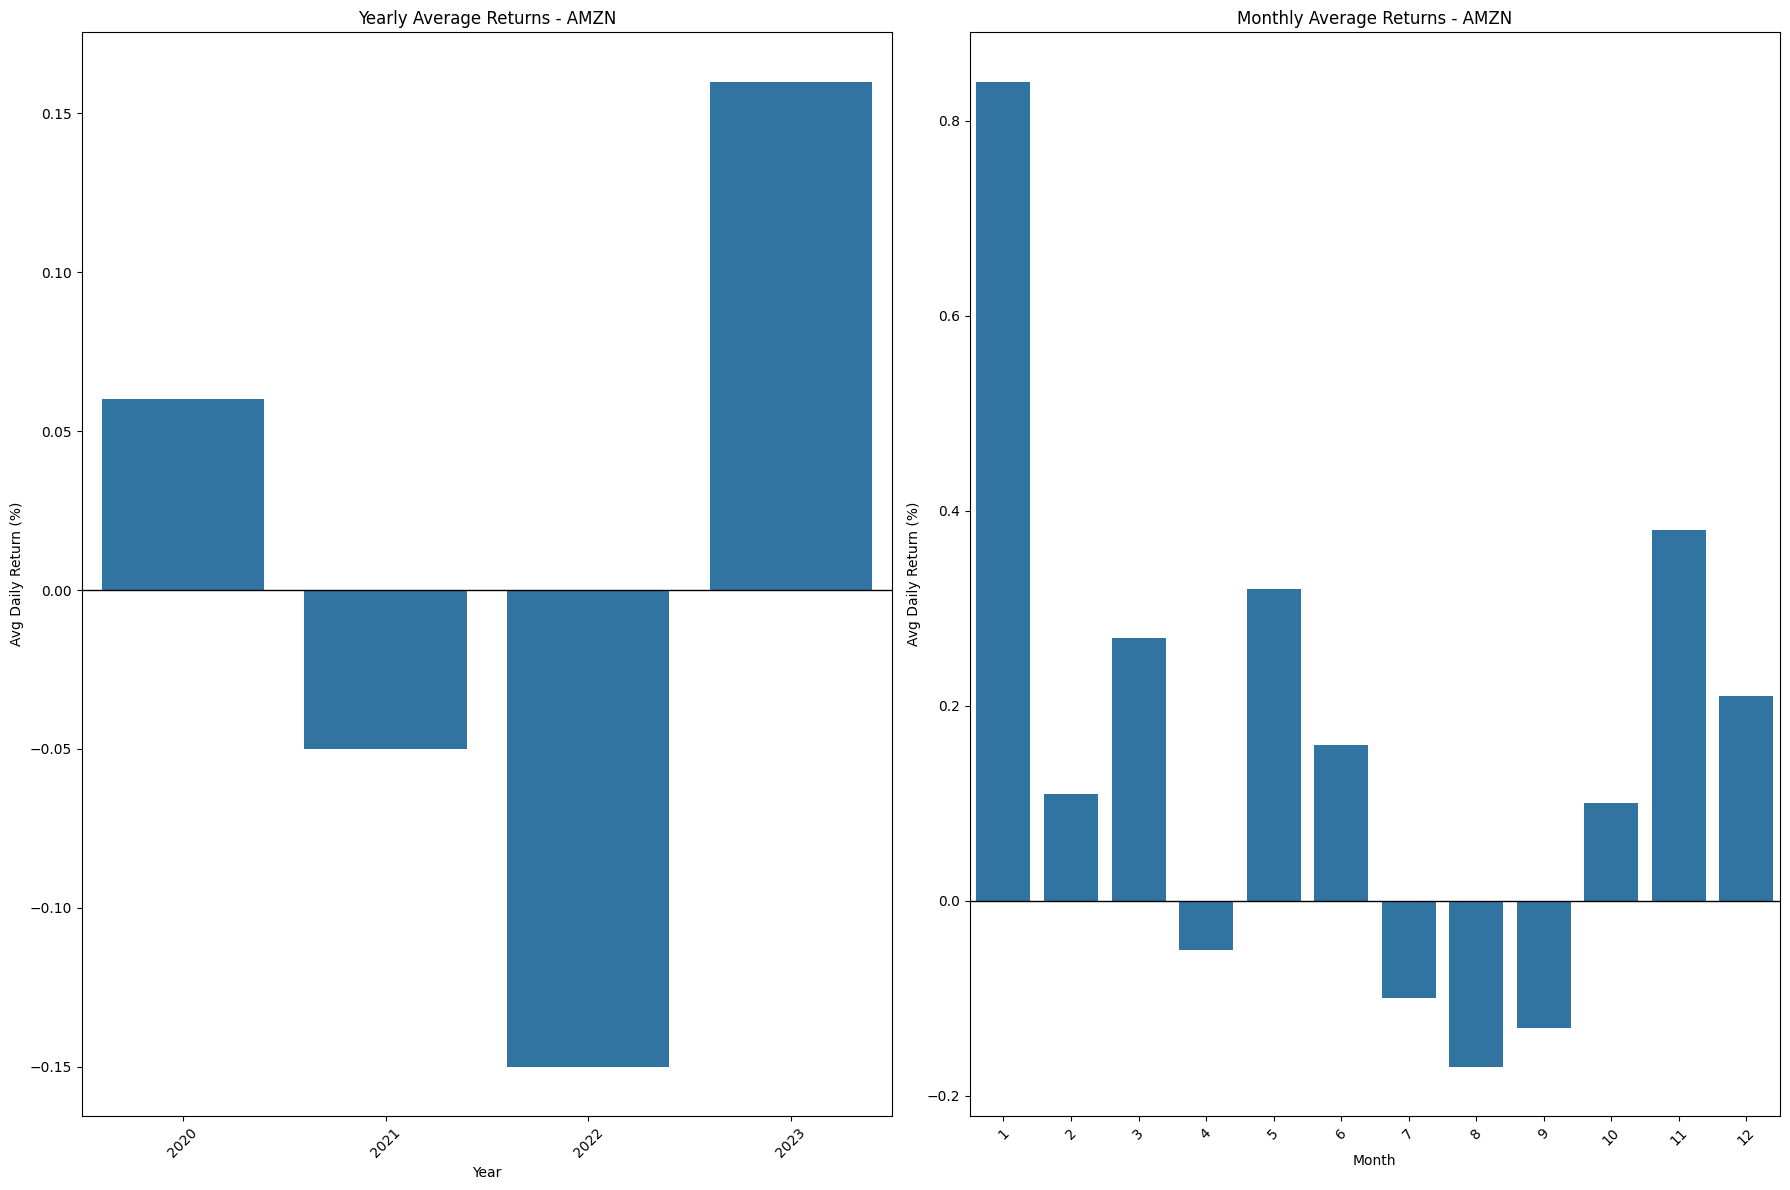

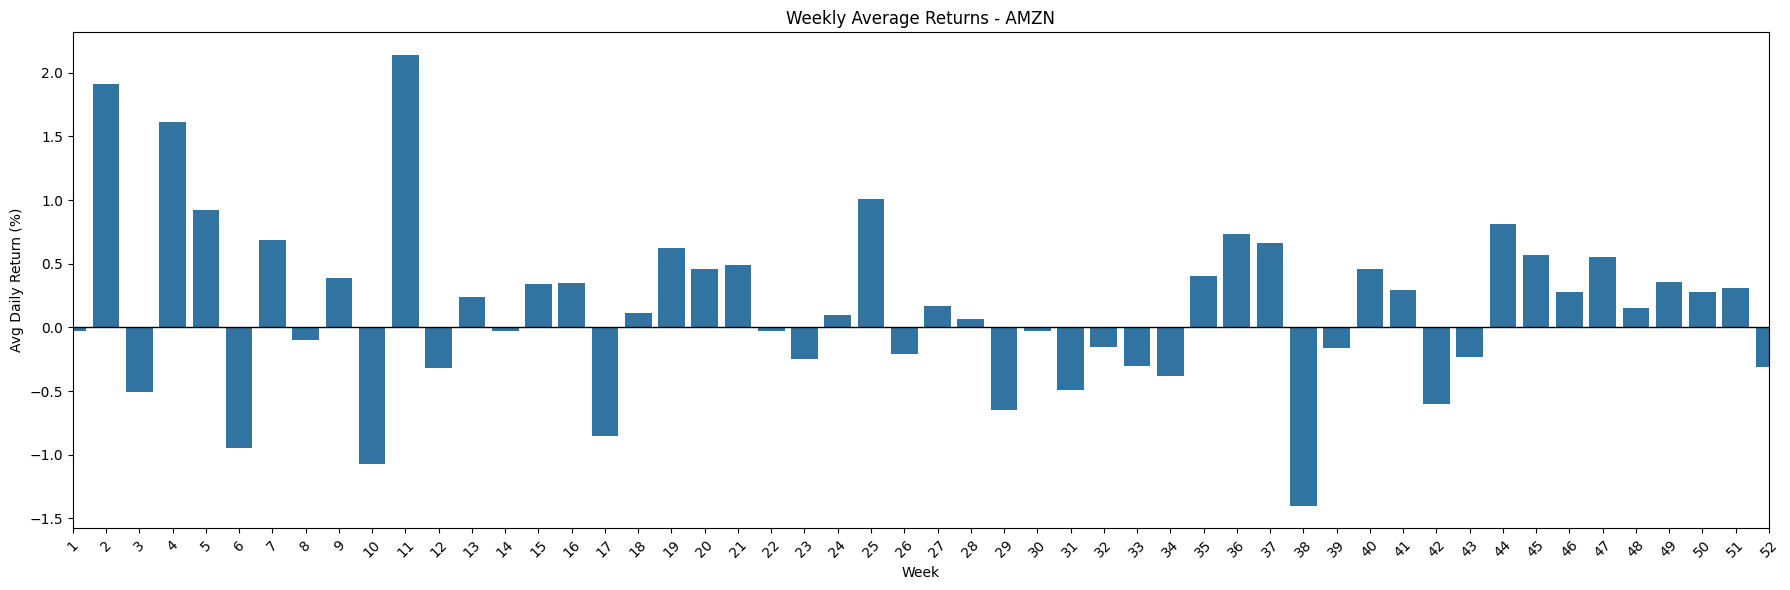

In [ ]:
def calculate_period_returns(stock_data):
    #Iterate for each stock of the stock_data dictionnary
    for ticker, data in stock_data.items():
        print(f"\nPeriod Returns Analysis for {ticker}")
        print("=" * 50)

        #Column for open and close prices of the stock
        close_col = f"('Close', '{ticker}')"
        open_col = f"('Open', '{ticker}')"

        # Calculate daily return and add new columns for year, month, and week
        data_with_returns = data.withColumn(
            "daily_return",
            spark_round((col(close_col) - col(open_col)) / col(open_col) * 100, 2)
        ).withColumn(
            "year", year(col("('Date', '')")) #Extraction of the year
        ).withColumn(
            "month", month(col("('Date', '')")) #Extraction of the month
        ).withColumn(
            "week", weekofyear(col("('Date', '')")) #Extraction of the week
        )

        # Display yearly average returns
        print("\nYearly Average Returns (in %):")
        yearly_returns = data_with_returns.groupBy("year") \
            .agg(spark_round(mean("daily_return"), 2).alias("avg_daily_return")) \
            .orderBy("year")
        yearly_returns.show()

        # Display montly average returns
        print("\nMonthly Average Returns (in %):")
        monthly_returns = data_with_returns.groupBy("year", "month") \
            .agg(spark_round(mean("daily_return"), 2).alias("avg_daily_return")) \
            .orderBy(col("year").desc(), col("month").desc()) \
            .limit(12)
        monthly_returns.show()

        # Display weekly average returns
        print("\nWeekly Average Returns (in %):")
        weekly_returns = data_with_returns.groupBy("year", "week") \
            .agg(spark_round(mean("daily_return"), 2).alias("avg_daily_return")) \
            .orderBy(col("year").desc(), col("week").desc()) \
            .limit(52)
        weekly_returns.show()

        #Convert to pandas for displaying graph
        yearly_returns_pandas = yearly_returns.toPandas()
        monthly_returns_pandas = monthly_returns.toPandas()
        weekly_returns_pandas = weekly_returns.toPandas()

        fig, axes = plt.subplots(1, 2, figsize=(18, 12))

        #First graph for yearly average returns
        sns.barplot(x="year", y="avg_daily_return", data=yearly_returns_pandas, ax=axes[0])
        axes[0].set_title(f"Yearly Average Returns - {ticker}")
        axes[0].set_xlabel("Year")
        axes[0].set_ylabel("Avg Daily Return (%)")
        axes[0].axhline(0, color='black', linewidth=1)
        axes[0].tick_params(axis='x', rotation=45)

        #Second graph for monthly average returns
        sns.barplot(x="month", y="avg_daily_return", data=monthly_returns_pandas, ax=axes[1])
        axes[1].set_title(f"Monthly Average Returns - {ticker}")
        axes[1].set_xlabel("Month")
        axes[1].set_ylabel("Avg Daily Return (%)")
        axes[1].axhline(0, color='black', linewidth=1)
        axes[1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

        #Third graph for weekly average returns
        fig, ax = plt.subplots(figsize=(18, 6))
        sns.barplot(x="week", y="avg_daily_return", data=weekly_returns_pandas, ax=ax)
        ax.set_title(f"Weekly Average Returns - {ticker}")
        ax.set_xlabel("Week")
        ax.set_ylabel("Avg Daily Return (%)")
        ax.set_xlim(0, 51)
        ax.axhline(0, color='black', linewidth=1)
        ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

calculate_period_returns(stock_data)


#### Let's calculate the moving average for the stock prices

##### It computes the 5-day moving averages for both opening and closing prices as asked,then we showed the price trends andf create new columns with averages
##### The user will be able to enter the starting date he want with dropdowns and submit it with a button

In [ ]:
def calculate_moving_average(stock_data, window_size=5, start_date=None):
    # We create an Output widget to directly display results under the button
    output = widgets.Output()
    with output:
        #Iterate for each stock of the stock_data dictionnary
        for ticker, data in stock_data.items():
            print(f"\n{'='*50}")
            print(f"{'Moving Average Analysis for ' + ticker:^50}")
            print(f"{'='*50}")

            #Column for open and close prices of the stock
            open_col = f"('Open', '{ticker}')"
            close_col = f"('Close', '{ticker}')"

            #Filter the date to get the one after the start date we selected
            if start_date:
                data = data.filter(col("('Date', '')") >= start_date)

            # Define the window for moving average calculation
            windowSpec = Window.orderBy("('Date', '')").rowsBetween(-(window_size-1), 0)

            #Calculate mooving average for open and closing prices
            data_with_ma = data.withColumn(
                "MA_Open",
                spark_round(avg(col(open_col)).over(windowSpec), 2)
            ).withColumn(
                "MA_Close",
                spark_round(avg(col(close_col)).over(windowSpec), 2)
            )

            #Rename the column for beauty
            data_with_ma = data_with_ma.withColumnRenamed("('Date', '')", "Date")\
                                       .withColumnRenamed(f"('Open', '{ticker}')", "Open")\
                                       .withColumnRenamed(f"('Close', '{ticker}')", "Close")

            #Diplay result
            print(f"\n{'-'*50}")
            print(f"First {window_size} rows of Moving Averages for {ticker} starting from {start_date} (in $):")
            print(f"{'-'*50}")
            data_with_ma.select(
                "Date",
                "MA_Open",
                "MA_Close"
            ).show(window_size, truncate=False)

    return output


def display_calculate_moving_average():
    #A year dropdown to choose the year we want with 2020, 2021, 2022 and 2023 options
    year_dropdown = widgets.Dropdown(
        options=[2020, 2021, 2022, 2023],
        description='Year:'
    )

    #A month dropdown to choose the month we want
    month_dropdown = widgets.Dropdown(
        options=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        description='Month:'
    )

    #A day dropdown to choose the month we want
    day_dropdown = widgets.Dropdown(
        options=[i for i in range(1, 32)],
        description='Day:'
    )

    #Button to submit
    button = widgets.Button(
        description="Calculate Moving Average",
        layout=widgets.Layout(width='200px')
    )

    output_widget = widgets.Output()

    #Def what happend when we click on the button
    def on_button_click(b):
        #Take the value we selected in the dropdowns
        year = year_dropdown.value
        month = month_dropdown.value
        day = day_dropdown.value
        start_date = f"{year}-{month:02d}-{day:02d}"

        #Call the principal function
        result_output = calculate_moving_average(stock_data, start_date=start_date)

        #delete the precedent output if there is one
        output_widget.clear_output(wait=True)
        with output_widget:
            #Display the output
            display(result_output)

    #When we click on the button, call the function def on button click
    button.on_click(on_button_click)


    #For beauty organize buttons and dropdown where we want
    date_widgets = widgets.HBox([day_dropdown, month_dropdown, year_dropdown], layout=widgets.Layout(justify_content='center', margin='20px 20px'))
    button_container = widgets.HBox([button], layout=widgets.Layout(justify_content='center', margin='20px 0px'))

    #Display everything
    display(date_widgets, button_container, output_widget)

#Call the function
display_calculate_moving_average()





Output()

#### Calculate the correlation between two stocks

##### --> Measure and interpret the correlation between closing prices of two selected stocks
##### --> Show their relationship strength and direction
##### --> We also include interpretation of correlation coefficient by using some conditions.

##### The user will be able to choose the 2 stocks he want to calculate the correlation between them with 2 dropdowns. If a user choose 2 times the same stock, we will get an error

In [ ]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']

def calculate_correlation_two_stocks(stock_data, ticker1, ticker2):
    # We create an Output widget to directly display results under the button
    output = widgets.Output()
    with output:
        #Stock we selected. We rename the column ('Date', '') to date
        stock1_data = stock_data[ticker1].withColumnRenamed("('Date', '')", "date")
        stock2_data = stock_data[ticker2].withColumnRenamed("('Date', '')", "date")

        #Specification of the Close for each stock
        close_col1 = f"('Close', '{ticker1}')"
        close_col2 = f"('Close', '{ticker2}')"

        #Combine both stocks data on the date column
        combined_data = stock1_data.join(stock2_data, "date", "inner")

        #Calculate the correlation between the closing prices of the 2 stocks
        correlation = combined_data.select(
            spark_round(corr(col(close_col1), col(close_col2)), 3).alias("correlation")
        ).collect()[0]["correlation"]

        print(f"\nCorrelation Analysis between {ticker1} and {ticker2}")
        print("=" * 50)
        print(f"Correlation coefficient: {correlation}")

        #Interpretation of the correlation
        print("\nInterpretation:")
        if correlation >= 0.7:
            print("Strong positive correlation")
        elif correlation >= 0.3:
            print("Moderate positive correlation")
        elif correlation > -0.3:
            print("Weak or no correlation")
        elif correlation > -0.7:
            print("Moderate negative correlation")
        else:
            print("Strong negative correlation")

    return output

def display_calculate_correlation_two_stocks(stock_data):
    #A dropdown to choose the first stock we want
    ticker1_selector = widgets.Dropdown(
        options=tickers,
        description='Stock 1:',
        value='AAPL'
    )

    #A dropdown to choose the second stock we want
    ticker2_selector = widgets.Dropdown(
        options=tickers,
        description='Stock 2:',
        value='MSFT'
    )

    #Button to submit our choice
    button = widgets.Button(description="Calculate Correlation")

    output_widget = widgets.Output()

    #Def what happend when we click on the button
    def on_button_click(b):
        #Take the value we selected in the dropdowns
        ticker1 = ticker1_selector.value
        ticker2 = ticker2_selector.value
        #Call the principal function
        result_output = calculate_correlation_two_stocks(stock_data, ticker1, ticker2)

        #delete the precedent output if there is one
        output_widget.clear_output(wait=True)
        with output_widget:
            #Display the output
            display(result_output)

    button.on_click(on_button_click)

    #For beauty display buttons and dropdown where we want
    dropdowns_box = widgets.HBox([ticker1_selector, ticker2_selector], layout=widgets.Layout(justify_content='center'))
    button_container = widgets.HBox([button], layout=widgets.Layout(justify_content='center', margin='20px 0px'))

    #Display everything
    display(dropdowns_box, button_container, output_widget)

#Call the function
display_calculate_correlation_two_stocks(stock_data)




Output()

#### Return rate of the stocks
##### By computing the return rates over multiple timeframes for each stock using closing prices

In [ ]:
def calculate_return_rates(stock_data):
    all_return_rates = {}

    #Iterate for each stock of the stock_data dictionnary
    for ticker, data in stock_data.items():
        print(f"\nReturn Rates for {ticker}")
        print("=" * 50)

        close_col = f"('Close', '{ticker}')"
        windowSpec = Window.orderBy("('Date', '')")

        #Calculate return rates
        return_rates = data.withColumn(
            "weekly_return",
            spark_round(((col(close_col) - lag(col(close_col), 5).over(windowSpec)) /
                        lag(col(close_col), 5).over(windowSpec)) * 100, 2)
        ).withColumn(
            "monthly_return",
            spark_round(((col(close_col) - lag(col(close_col), 20).over(windowSpec)) /
                        lag(col(close_col), 20).over(windowSpec)) * 100, 2)
        ).withColumn(
            "yearly_return",
            spark_round(((col(close_col) - lag(col(close_col), 252).over(windowSpec)) /
                        lag(col(close_col), 252).over(windowSpec)) * 100, 2)
        )

        #Add % behind our values
        return_rates = return_rates.withColumn(
            "weekly_return", concat(col("weekly_return"), lit(" %"))
        ).withColumn(
            "monthly_return", concat(col("monthly_return"), lit(" %"))
        ).withColumn(
            "yearly_return", concat(col("yearly_return"), lit(" %"))
        )


        #Print all the informations we wanted
        print("\nSome return rates:")
        return_rates.select(
            "('Date', '')",
            "weekly_return",
            "monthly_return",
            "yearly_return"
        ).orderBy(col("('Date', '')").desc()).show()

        all_return_rates[ticker] = return_rates

    return all_return_rates


#Call the function
return_rates_data = calculate_return_rates(stock_data)



Return Rates for AAPL

Some return rates:
+-------------------+-------------+--------------+-------------+
|       ('Date', '')|weekly_return|monthly_return|yearly_return|
+-------------------+-------------+--------------+-------------+
|2023-12-29 00:00:00|       -1.1 %|        1.36 %|      53.61 %|
|2023-12-28 00:00:00|      -0.64 %|        2.22 %|      49.71 %|
|2023-12-27 00:00:00|      -1.92 %|        1.44 %|       47.3 %|
|2023-12-26 00:00:00|      -1.45 %|        1.72 %|      46.81 %|
|2023-12-22 00:00:00|      -2.01 %|        1.91 %|      43.73 %|
|2023-12-21 00:00:00|      -1.73 %|        1.76 %|      47.97 %|
|2023-12-20 00:00:00|      -1.58 %|         2.2 %|      48.01 %|
|2023-12-19 00:00:00|       1.15 %|        2.87 %|      47.23 %|
|2023-12-18 00:00:00|        1.4 %|        3.27 %|      44.31 %|
|2023-12-15 00:00:00|       0.95 %|        4.14 %|      38.73 %|
|2023-12-14 00:00:00|       1.98 %|        5.37 %|      36.95 %|
|2023-12-13 00:00:00|       2.93 %|        5.61

#### Get the best return rate

##### We identify the best performing stock in a given time period by comparing return rates of all stocks.
##### The user will be able to choose the starting date he want and the period (month, year) with dropdowns.
##### The result will be displayed writed and in the form of a graph with the 4 stocks as x and the return rate % as y. Moreover, the bar of the best return rate will be in a gold color and the other will be black.

In [ ]:
def find_best_stock(stock_data, start_date, period):
    # We create an Output widget to directly display results under the button
    output = widgets.Output()
    with output:
        best_ticker = None #Initialize the best stock at none
        best_return = float('-inf') #Initialize the best return to -inf therefore, even if the return rate is negative, it will be higher than -inf
        #We initialize list for our bar graph to keep all the values through the loop
        tickers = []
        returns = []
        colors = []

        print(f'Selected date: {start_date}')
        print(f'Selected period: {period}\n')

        #We choose the period with dropdown. Therefore we need to know what we selected
        if period == 'month':
            date_format_str = "yyyy-MM"
        elif period == 'year':
            date_format_str = "yyyy"

        print('Stock Return Rates')

        #Iterate for each stock of the stock_data dictionnary
        for ticker, data in stock_data.items():
            period_label = start_date[:7] if period == 'month' else start_date[:4]

            period_data = data.withColumn("period", date_format(col("('Date', '')"), date_format_str)) \
                              .filter(col("period") == period_label)

            if period_data.count() > 0:
                #Select the first and last price of the period
                first_price = period_data.orderBy("('Date', '')").first()[f"('Close', '{ticker}')"]
                last_price = period_data.orderBy("('Date', '')").tail(1)[0][f"('Close', '{ticker}')"]

                #Calculae the return rate
                return_rate = round(((last_price - first_price) / first_price) * 100, 2)

                #Add the name of the thicker and its return rate value to the list we created for the graph
                tickers.append(ticker)
                returns.append(return_rate)

                print(f"{ticker}: {return_rate}%")

                #We compare through the loop to keep the stock with the best return rate
                if return_rate > best_return:
                    best_return = return_rate
                    best_ticker = ticker

        print(f"\nThe best stock is: {best_ticker} with a return rate of {best_return}%")

        for return_rate in returns:
            if return_rate == best_return:
                colors.append('gold') #The bar which will represent the best return rate will be gold color
            else:
                colors.append('black') #All the others will be black

        #Display a bar graph of the return rate for each stock
        plt.figure(figsize=(10, 6))
        sns.barplot(x=tickers, y=returns, palette=colors)
        plt.xlabel('Stocks')
        plt.ylabel('Return Rate (%)')
        plt.title(f"Stock Return Rates from {start_date} for a period of one {period}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return output

def display_find_best_stock():

    #A day dropdown to choose the month we want
    day_dropdown = widgets.Dropdown(
        options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
        description='Day :',
        layout=widgets.Layout(width='150px')
    )

    #A month dropdown to choose the month we want
    month_dropdown = widgets.Dropdown(
        options= ['January (01)', 'February (02)', 'March (03)', 'April (04)', 'May (05)', 'June (06)', 'July (07)', 'August (08)', 'September (09)', 'October (10)', 'November (11)', 'December (12)'],
        description='Month :',
        layout=widgets.Layout(width='220px')
    )

    #A year dropdown to choose the year we want with 2020, 2021, 2022 and 2023 options
    year_dropdown = widgets.Dropdown(
        options = [2020, 2021, 2022, 2023, 2024],
        description='Year :',
        layout=widgets.Layout(width='150px')
    )

    #A dropdown to enter the period we want
    period_text = widgets.Dropdown(
        options = ['month', 'year'],
        description='Period :',
    )

    #Button to submit
    button = widgets.Button(
        description="Submit",
        layout=widgets.Layout(width='150px')
    )

    #For beauty (display first 3 dropdown on the same row), (space between button and dropdown and align it in the center ...)
    date_widgets = widgets.HBox([day_dropdown, month_dropdown, year_dropdown], layout=widgets.Layout(justify_content='center', margin='20px 20px'))
    period_container = widgets.HBox([period_text], layout=widgets.Layout(justify_content='center', margin='20px'))
    button_container = widgets.HBox([button], layout=widgets.Layout(justify_content='center', margin='20px 0px'))
    output_widget = widgets.Output()

    #When we click on the button
    def on_button_click(b):

        #Take the value we selected in the dropdown
        day = day_dropdown.value
        month = month_dropdown.value
        year = year_dropdown.value
        period = period_text.value

        #Take the number for the month we selected in the dropdown
        month_map = {
            'January (01)': 1, 'February (02)': 2, 'March (03)': 3, 'April (04)': 4, 'May (05)': 5,
            'June (06)': 6, 'July (07)': 7, 'August (08)': 8, 'September (09)': 9, 'October (10)': 10,
            'November (11)': 11, 'December (12)': 12
        }
        month_in_number = month_map.get(month, None)

        #Convert the different day, month and year to a date
        start_date = f"{year}-{month_in_number:02d}-{day:02d}"



        #Call the find_best_stock function
        result_output = find_best_stock(stock_data, start_date, period)

        #delete the precedent output if there is one
        output_widget.clear_output(wait=True)
        #Display the output
        with output_widget:
            display(result_output)

    button.on_click(on_button_click)

    #Display everything
    display(date_widgets, period_container, button_container, output_widget)

#Call the function
display_find_best_stock()





Output()

### 8 Insights we got from these data

#### 1 Risk management
By using analyze_correlation(), we found out that Apple and microsoft have a strong positive correlation between each other, it means that they react similarly to market conditions, when you are managing many stocks it is better to have a low correlation so that when you got a problem you know that the other ones are not facing the same issues.

#### 2 Market leaders
By running find_best_stock(), we found out that Amazon outperformed other tech stocks in Q1 2023 with 20.17 % return.

#### 3 Best Investment Timing
By running calculate_daily_returns() , we could see that Apple had a daily return of 0.12 suggesting it has best trading days than the other which can help when talking about entry and exit of a market.

#### 4 Market Trends
With calculate_moving_average(), we showed these companies moving averages which give indications on their trend directions.

#### 5 Price Volatility
analyze_price_variations() shows that on 2020-01-06 Microsoft had the lowest day-to-day variations, indicating stability which help to assess risk levels.

#### 6 Statistical Performance
get_descriptive_statistics() shows that Google had the lowest standard deviation suggesting it being a most stable stock.

#### 7 Investment Horizons
calculate_period_returns() shows when the stocks performed the best in order to do better investments.

#### 8 Data Quality
analyze_missing_values() checks data completeness and will tell us if the data we are working on can be trust. Here with the four stocks we got 0 missing values which ensures reliable analysis.

#### this stock analysis project was developed through:
+ Extensive research across financial and technical sources
+ Implementation of analysis methods
+ programming expertise.

We successfully implemented:
- Prices and returns calculations
- Volatility measures
- Correlation analyses
- Technical indicators

##### It effectively combines technical skills, financial knowledge, and practical application, making it a valuable learning and analysis tool for us.

#### Little Menu to be able to call every function we want:
    -> We need before to call all the functions one by one, pip install all of what we need and import the dataframe to be able to use this menu

##### When we click on a button, it calls the function we want.
    

In [ ]:
output = widgets.Output()

#Dictionnary of all our functions
functions = {
    "Show Stock Head & Tail": lambda: show_stock_head_tail(stock_data),
    "Get Observations Count": lambda: get_observations_count(stock_data),
    "Analyze Time Period": lambda: analyze_time_period(stock_data),
    "Get Descriptive Statistics": lambda: get_descriptive_statistics(stock_data),
    "Analyze Missing Values": lambda: analyze_missing_values(stock_data),
    "Analyze Correlations": lambda: analyze_correlations(stock_data),
    "Analyze Price Averages": lambda: analyze_price_averages(stock_data),
    "Display Price Variations": lambda: display_analyze_price_variations(stock_data),
    "Calculate Daily Returns": lambda: display_calculate_daily_returns(),
    "Find Highest Daily Returns": lambda: print(find_highest_daily_returns(stock_data)),
    "Calculate Period Returns": lambda: calculate_period_returns(stock_data),
    "Correlation Between Two Stocks": lambda: display_calculate_correlation_two_stocks(stock_data),
    "Calculate Return Rates": lambda: print(calculate_return_rates(stock_data)),
    "Find Best Stock": lambda: display_find_best_stock(),
}

buttons = []
# we make a loop through our dictionnary
for name, function in functions.items():
    #We set the name of our buttons, the keys of the dictionnary
    button = widgets.Button(
        description=name,
        layout=widgets.Layout(width="200px")
    )

    #When we click, we call the value (function) in the dictionnary
    def on_button_click(b, function=function):
        with output:
            output.clear_output()
            function() #Call the function

    button.on_click(on_button_click)
    buttons.append(button)

# Title
title = widgets.HTML("<h2 style='text-align: center;'>Functions menu (need to call all the functions separatly before)</h2>")

#We display our buttons as we want, with here 4 buttons per row
buttons_grid = widgets.GridBox(
    buttons,
    layout=widgets.Layout(
        grid_template_columns="repeat(4, 1fr)",
        grid_gap="10px",
        justify_items="center",
        border="2px solid black", #Border around all the buttons for beauyt
        padding="10px",
        margin="10px auto",
        width="90%"
    )
)

# display
display(title, buttons_grid, output)


HTML(value="<h2 style='text-align: center;'>Functions menu (need to call all the functions separatly before)</…

GridBox(children=(Button(description='Show Stock Head & Tail', layout=Layout(width='200px'), style=ButtonStyle…

Output()